# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

from imblearn.over_sampling import SMOTE

# Basic overview of the data

In [2]:
# Import datasets
train_df = pd.read_csv("csv_files/train.csv")
test_df = pd.read_csv("csv_files/test.csv")

print('Training dataset: ')
display(train_df.head(3))

print('Testing dataset: ')
display(test_df.head(3))

# Check for any duplicates
print(f"Duplicates in Train Dataset is:{train_df.duplicated().sum()},({100*train_df.duplicated().sum()/len(train_df)})%")
print(f"Duplicates in Test Dataset is:{test_df.duplicated().sum()},({100*test_df.duplicated().sum()/len(test_df)})%")


Training dataset: 


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


Testing dataset: 


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus


Duplicates in Train Dataset is:0,(0.0)%
Duplicates in Test Dataset is:0,(0.0)%


### Insights

1. There is no duplication so there is no need to drop duplicates. Acts more as a sanity check.

In [3]:
# Calculate missing data statistics for the training set
train_missing = train_df.isnull().sum()[train_df.isnull().sum() > 0].to_frame().rename(columns={0: "Number of Missing Values (Train)"})
train_missing["% of Missing Values (Train)"] = round((100 * train_missing["Number of Missing Values (Train)"] / len(train_df)), 2)

# Calculate missing data statistics for the testing set
test_missing = test_df.isnull().sum()[test_df.isnull().sum() > 0].to_frame().rename(columns={0: "Number of Missing Values (Test)"})
test_missing["% of Missing Values (Test)"] = round((100 * test_missing["Number of Missing Values (Test)"] / len(test_df)), 2)

# Combine the statistics into a single DataFrame by joining on the index (feature names)
combined_missing = train_missing.join(test_missing, how='outer')

# Reset the index to turn the index (feature names) into a regular column
combined_missing.reset_index(inplace=True)
combined_missing.rename(columns={"index": "Feature"}, inplace=True)

# Display the combined DataFrame
display(combined_missing)


,Feature,Number of Missing Values (Train),% of Missing Values (Train),Number of Missing Values (Test),% of Missing Values (Test)
0,Age,179,2.06,91,2.13
1,Cabin,199,2.29,100,2.34
2,CryoSleep,217,2.50,93,2.17
3,Destination,182,2.09,92,2.15
4,FoodCourt,183,2.11,106,2.48
5,HomePlanet,201,2.31,87,2.03
6,Name,200,2.30,94,2.20
7,RoomService,181,2.08,82,1.92
8,ShoppingMall,208,2.39,98,2.29
9,Spa,183,2.11,101,2.36


### Insights

1. There is a very small percentage of data missing in both training and testing data. 
2. It will be easily fillable with imputing more suitable values rather than dropping the rows.

In [4]:
print("cardinality of categorical features in training datasets is:")
print(train_df.select_dtypes(include="object").nunique())

print("\n","-"*70)

print("\nCardinality of categorical features in testing datsets is:")
print(test_df.select_dtypes(include="object").nunique())

cardinality of categorical features in training datasets is:
PassengerId    8693
HomePlanet        3
CryoSleep         2
Cabin          6560
Destination       3
VIP               2
Name           8473
dtype: int64

 ----------------------------------------------------------------------

Cardinality of categorical features in testing datsets is:
PassengerId    4277
HomePlanet        3
CryoSleep         2
Cabin          3265
Destination       3
VIP               2
Name           4176
dtype: int64


### Insights

1. We observe that the PassengerId, Cabin, and Name features of both datasets have high cardinality.
2. Typically, features with high cardinality are dropped. However, in this project, we will perform feature engineering and create new features from these features. 

# Deeper exploration of the data

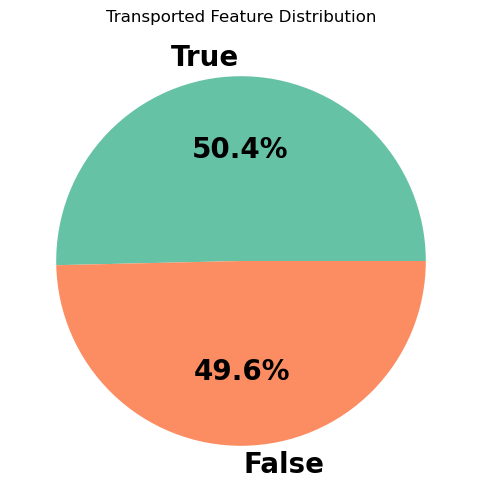

In [5]:
plt.figure(figsize=(10,6))
plt.pie(train_df["Transported"].value_counts(),labels=train_df["Transported"].value_counts().keys(),autopct="%1.1f%%",
       textprops={"fontsize":20,"fontweight":"black"},colors=sns.color_palette("Set2"))
plt.title("Transported Feature Distribution");

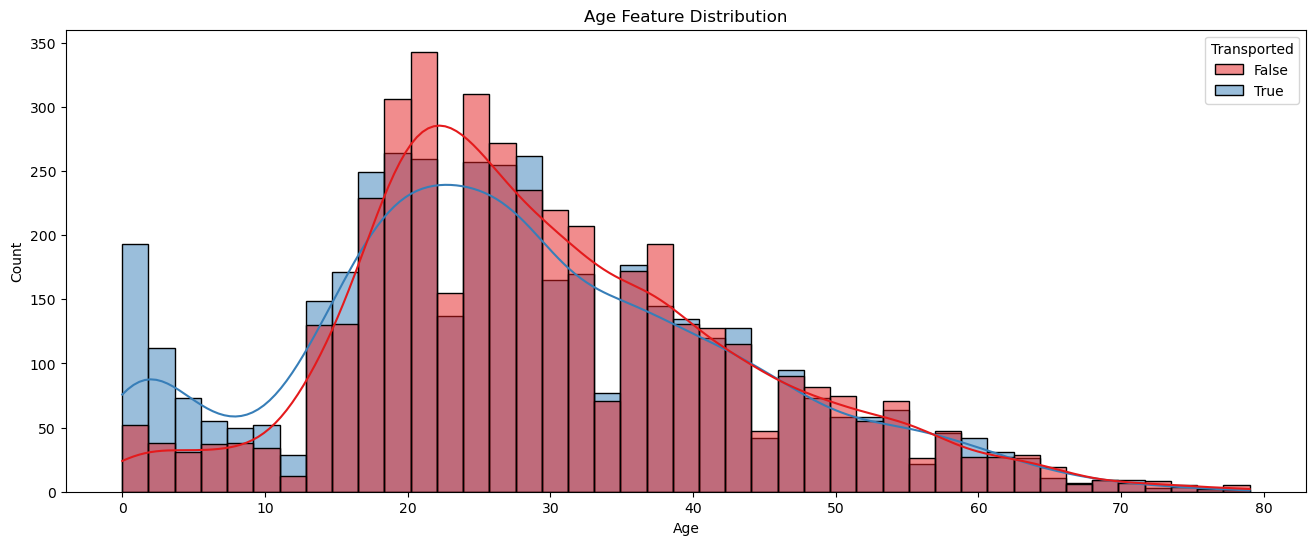

In [6]:
plt.figure(figsize=(16,6))
sns.histplot(x=train_df["Age"],hue="Transported",data=train_df,kde=True,palette="Set1")
plt.title("Age Feature Distribution");


- Most of the passengers were between the ages of 18-32.
- Passengers aged 0-18 are highly transported compared to not transported passengers, especially for those who were newborn.
- Passengers aged 18-32 are comparatively less transported compared to not transported passengers.
- Passengers above 32 seem to be equally transported compared to not transported passengers.


### Insights
We can create a new feature called Age-Category from age, in which we can split ages into different categories.


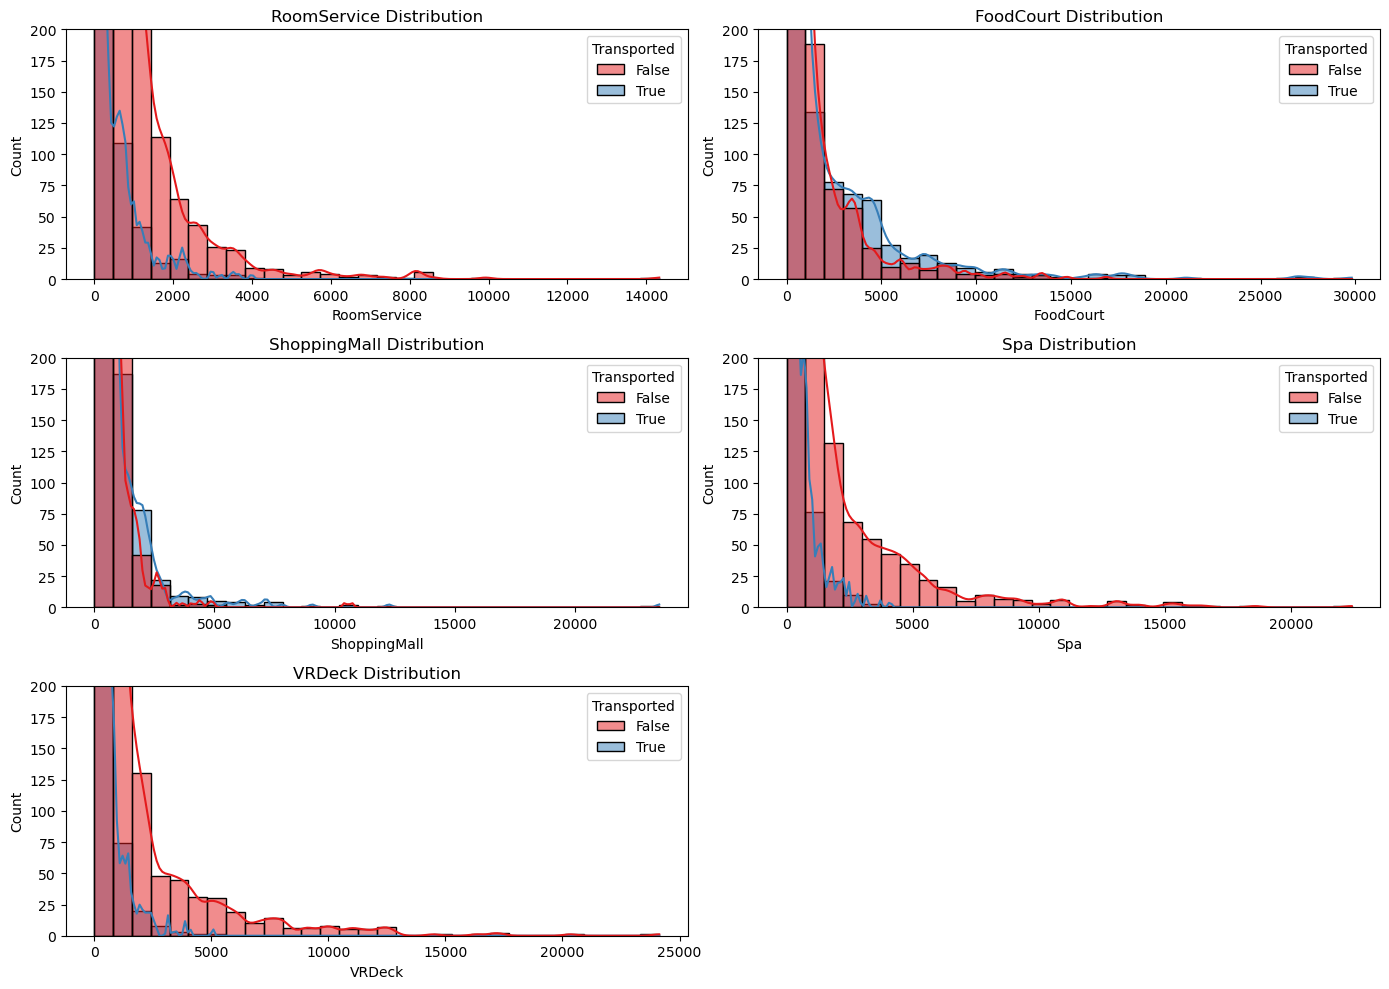

In [7]:
exp_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

plt.figure(figsize=(14,10))
for idx,column in enumerate(exp_cols):
    plt.subplot(3,2,idx+1)
    sns.histplot(x=column, hue="Transported", data=train_df,bins=30,kde=True,palette="Set1")
    plt.title(f"{column} Distribution")
    plt.ylim(0,200)
    plt.tight_layout()

### Insights

- Since all expenditure features have right-skewed distributions, we will transform these features to normal distributions using log-transformation before model building.
- We can create a new feature called Total Expenditure, indicating the total expenses of all different expenditures done by the passengers.
- Since most people's expenses are 0, we can create a new boolean feature called No Spending, indicating whether the passenger's total expense is 0 or not.
- We can split Total Expenditure into different categories of expenditure like Low, Medium, and High Expenses and create another new feature called Expenditure Category.


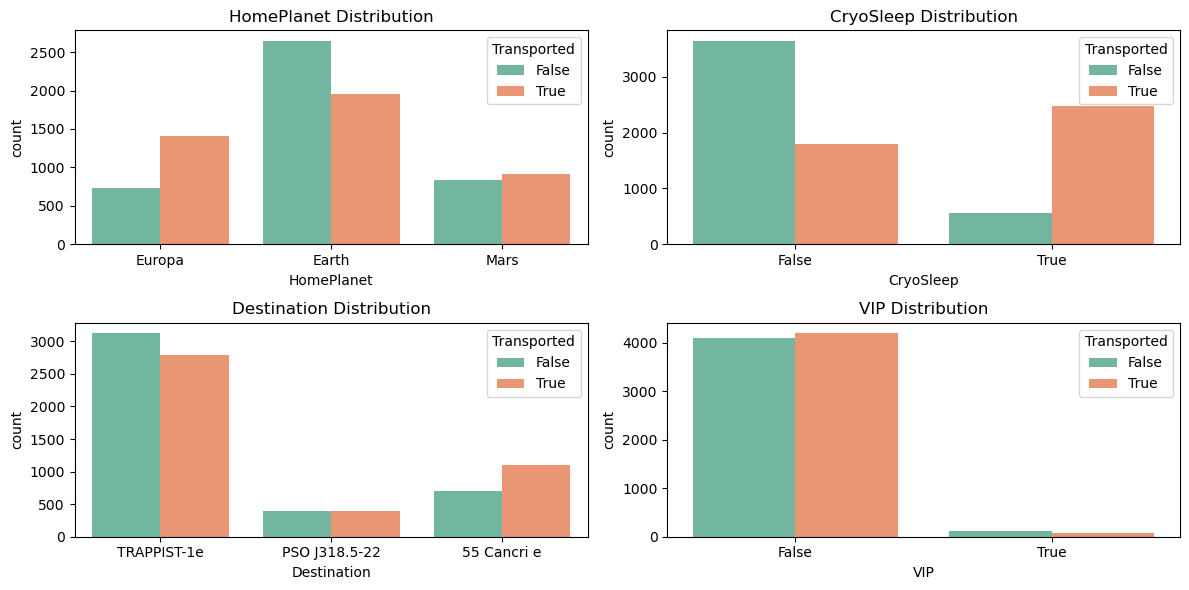

In [8]:
cat_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP"]

# Create a 2x2 subplot grid and set the overall figure size
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# Iterate over the columns and the corresponding axes
for idx, column in enumerate(cat_cols):
    # Create a countplot for each categorical column on its respective axis
    sns.countplot(x=column, hue="Transported", data=train_df, palette="Set2", ax=axes_flat[idx])
    # Set the title for each subplot
    axes_flat[idx].set_title(f"{column} Distribution")

plt.tight_layout()
plt.show()


### Insights
- In the HomePlanet feature, we observe that most passengers are from Earth. However, passengers from Earth are comparatively less transported, passengers from Mars are equally transported, and passengers from Europa are highly transported.
- In the Destination feature, we observe that most passengers are transported to Trappist-1e.
- Regarding the VIP feature, one category is dominating significantly over the others. Therefore, this feature doesn't seem to be useful and may lead to overfitting in our model.
- It's advisable to drop the VIP feature before building the model.

# Feature Engineering

### Feature engineering on PassangerID

- Each ID takes the form gggg_pp, where gggg indicates the group the passenger is traveling with and pp is their number of people within the group.
- To perform feature engineering on the PassengerId, we will create a new feature called Group_Size, indicating the total number of members present in each group.
- Additionally, we will create another new feature called Travelling Solo, indicating whether the passenger is traveling solo or in a group.</li>


In [9]:
def passengerid_new_features(df):
    
    #Splitting Group and Member values from "PassengerId" column.
    df["Group"] = df["PassengerId"].apply(lambda x: x.split("_")[0])
    df["Member"] =df["PassengerId"].apply(lambda x: x.split("_")[1])
    
    #Grouping the "Group" feature with respect to "member" feature to check which group is travelling with how many members
    x = df.groupby("Group")["Member"].count().sort_values()
    
    #Creating a set of group values which are travelling with more than 1 members.
    y = set(x[x>1].index)
    
    #Creating a new feature "Solo" which will indicate whether the person is travelling solo or not.
    df["Travelling_Solo"] = df["Group"].apply(lambda x: x not in y)
    
    #Creating a new feature "Group_size" which will indicate each group number of members.
    df["Group_Size"]=0
    for i in x.items():
        df.loc[df["Group"]==i[0],"Group_Size"]=i[1]
    
    # Remove 'Group' and 'Member' as we got group size and travel solo
    df.drop(columns=["Group","Member"],inplace=True)

passengerid_new_features(train_df)
passengerid_new_features(test_df)

display(train_df.head(3))

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Travelling_Solo,Group_Size
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,True,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,True,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,False,2


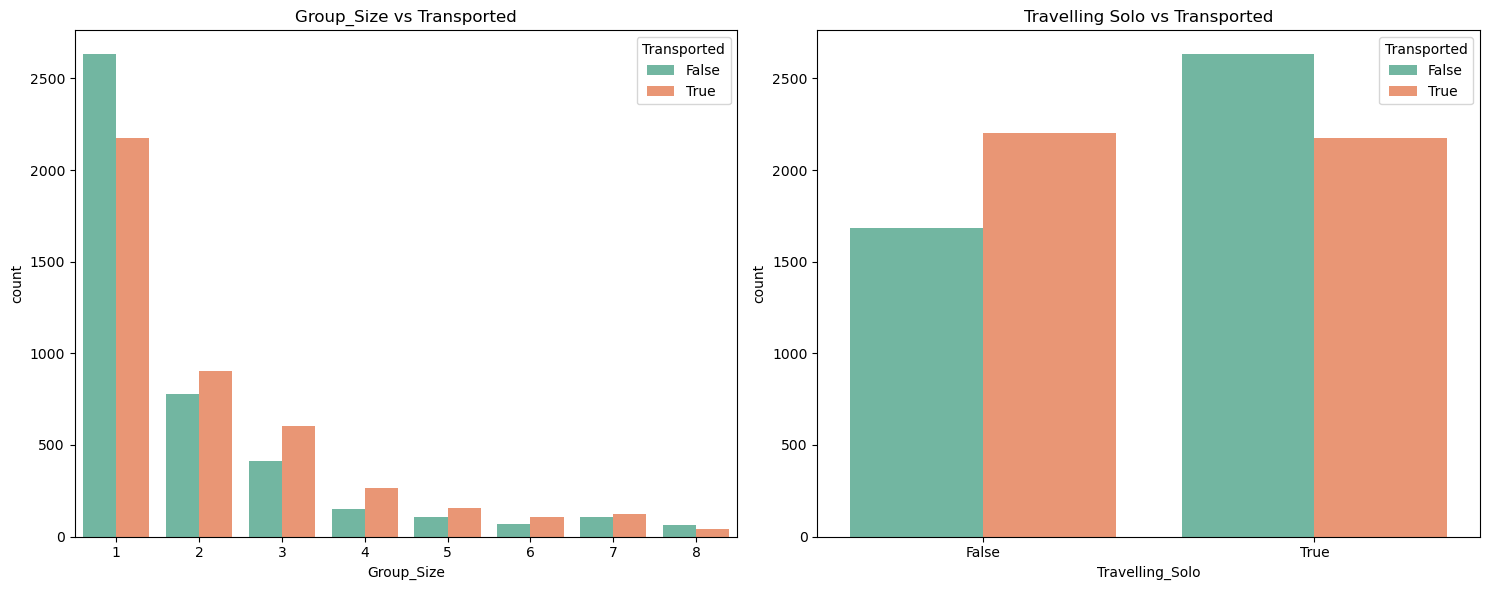

In [10]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.countplot(x="Group_Size", hue="Transported", data=train_df,palette="Set2")
plt.title("Group_Size vs Transported")

plt.subplot(1,2,2)
sns.countplot(x="Travelling_Solo", hue="Transported", data=train_df,palette="Set2")
plt.title("Travelling Solo vs Transported")
plt.tight_layout()
plt.show()

### Observation

- In the Group_Size feature, it's evident that most passengers are traveling alone.
- However, from the Travelling_Solo feature, we observe that passengers traveling solo are comparatively less transported when compared with passengers traveling in a group. 


### How will we do feature engineering on Cabin
- We understand that the cabin feature consists of deck/num/side, where deck represents the deck location, num represents the deck number, and side can be P for port or S for Starboard.
- To perform feature engineering on the Cabin feature, we will separate these three values and create three new features: Cabin_Deck, Cabin_Number, and Cabin_Side.
- Additionally, since the Cabin feature contains NaN values, we need to handle them appropriately to avoid errors during splitting. We will replace the NaN values in such a way that they can be split into all three new features accordingly.


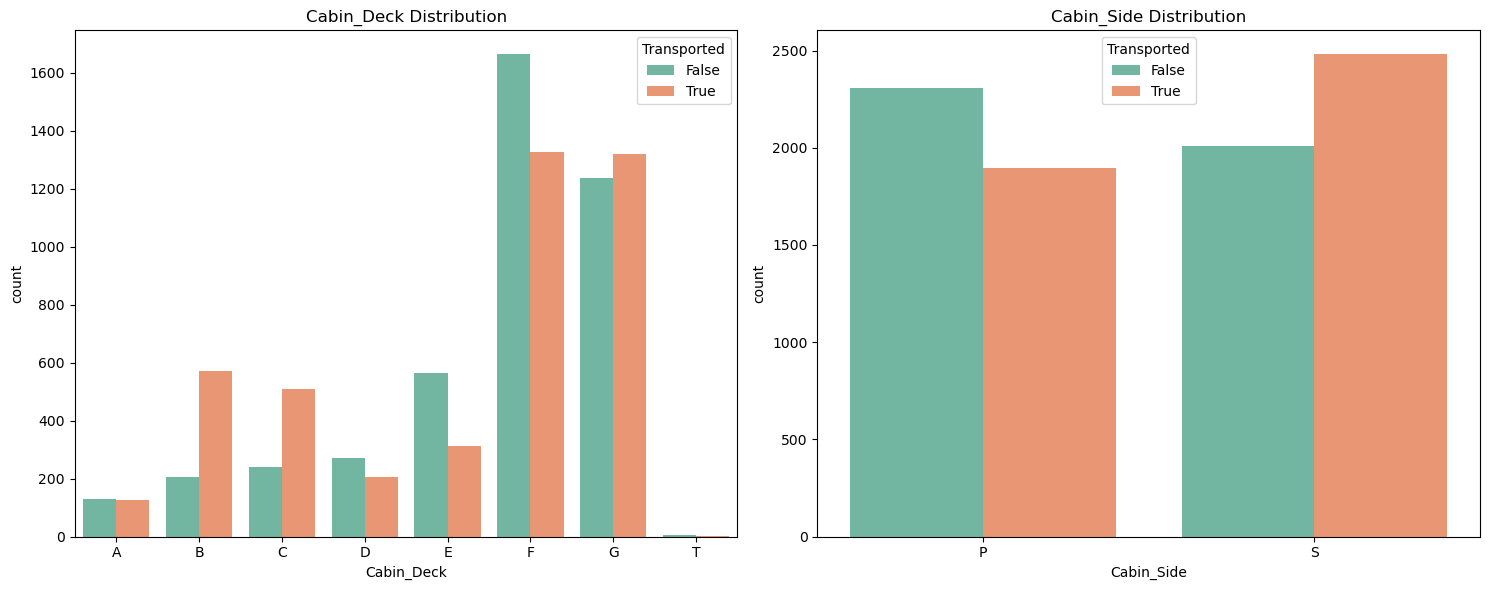

In [11]:
def cabin_new_feature(df):
    # Temporarily fill NaNs in 'Cabin' to facilitate splitting
    df["Cabin"].fillna("Unknown/Unknown/Unknown", inplace=True)
    
    # Split 'Cabin' into new features
    df["Cabin_Deck"] = df["Cabin"].apply(lambda x: x.split("/")[0])
    df["Cabin_Number"] = df["Cabin"].apply(lambda x: x.split("/")[1])
    df["Cabin_Side"] = df["Cabin"].apply(lambda x: x.split("/")[2])
    
    # Replace 'Unknown' with np.nan to facilitate numerical operations and maintain consistency
    cols = ["Cabin_Deck", "Cabin_Number", "Cabin_Side"]
    df[cols] = df[cols].replace("Unknown", np.nan)
    
    # Convert 'Cabin_Number' to numeric, errors='coerce' will convert non-numeric to NaN
    df["Cabin_Number"] = pd.to_numeric(df["Cabin_Number"], errors='coerce')
    
    # Fill missing values in new features
    df["Cabin_Deck"].fillna(df["Cabin_Deck"].mode()[0], inplace=True)
    df["Cabin_Side"].fillna(df["Cabin_Side"].mode()[0], inplace=True)
    df["Cabin_Number"].fillna(df["Cabin_Number"].median(), inplace=True)

cabin_new_feature(train_df)
cabin_new_feature(test_df)

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x="Cabin_Deck",hue="Transported", data=train_df, palette="Set2",order=["A","B","C","D","E","F","G","T"])
plt.title("Cabin_Deck Distribution")

plt.subplot(1,2,2)
sns.countplot(x="Cabin_Side", hue="Transported", data=train_df, palette="Set2")
plt.title("Cabin_Side Distribution")
plt.tight_layout()
plt.show()

### Insights
- The majority of people are from Cabin_Deck F & G.
- There are very few passengers in Cabin_Deck T.
- Passengers from Cabin Deck B & C are transported at a high rate.
- From Cabin_Side, approximately half of the passengers were from cabin side S and half from cabin side P.
- However, passengers from cabin side S are transported at a higher rate compared to those from cabin side P, despite both sides having an equal number of passengers.

Total Unique values present in Cabin_Number feature is: 1817
The Mean of Cabin_Number Feature is:  596.3989416772115
The Median of Cabin_Number Feature is: 427.0
The Minimum value of Cabin_Number feature is: 0
The Maximum value of Cabin_number Feature is: 1894


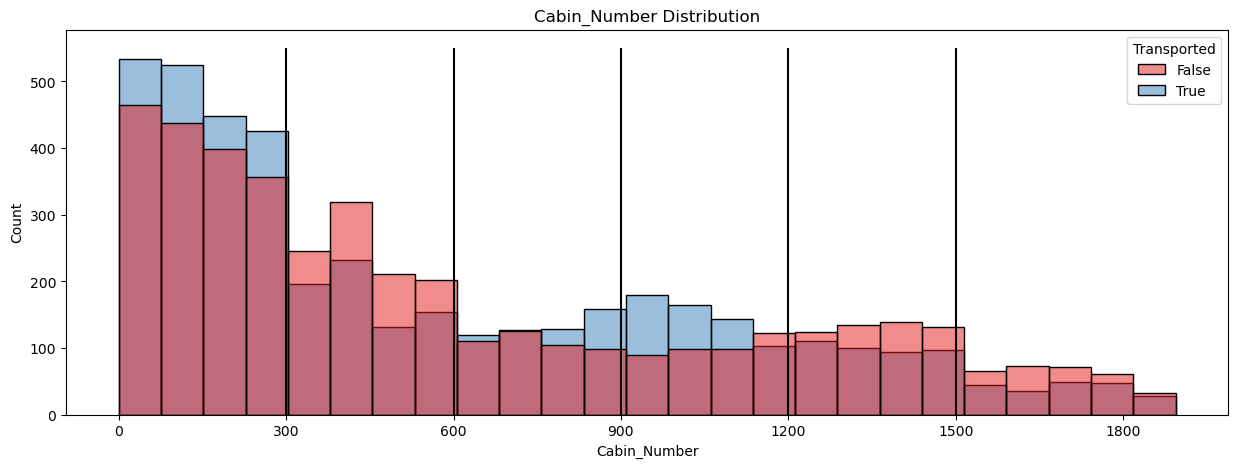

In [12]:
train_df["Cabin_Number"]=train_df["Cabin_Number"].astype(int)
test_df["Cabin_Number"]=test_df["Cabin_Number"].astype(int)

print("Total Unique values present in Cabin_Number feature is:",train_df["Cabin_Number"].nunique())
print("The Mean of Cabin_Number Feature is: ",train_df["Cabin_Number"].mean())
print("The Median of Cabin_Number Feature is:",train_df["Cabin_Number"].median())
print("The Minimum value of Cabin_Number feature is:",train_df["Cabin_Number"].min())
print("The Maximum value of Cabin_number Feature is:",train_df["Cabin_Number"].max())

plt.figure(figsize=(15,5))
sns.histplot(x="Cabin_Number",data=train_df,hue="Transported",palette="Set1")
plt.title("Cabin_Number Distribution")
plt.xticks(list(range(0,1900,300)))
plt.vlines(300,ymin=0,ymax=550,color="black")
plt.vlines(600,ymin=0,ymax=550,color="black")
plt.vlines(900,ymin=0,ymax=550,color="black")
plt.vlines(1200,ymin=0,ymax=550,color="black")
plt.vlines(1500,ymin=0,ymax=550,color="black")
plt.show()

In [13]:
def cabin_regions(df):
    df["Cabin_Region1"] = (df["Cabin_Number"]<300)
    df["Cabin_Region2"] = (df["Cabin_Number"]>=300) & (df["Cabin_Number"]<600)
    df["Cabin_Region3"] = (df["Cabin_Number"]>=600) & (df["Cabin_Number"]<900)
    df["Cabin_Region4"] = (df["Cabin_Number"]>=900) & (df["Cabin_Number"]<1200)
    df["Cabin_Region5"] = (df["Cabin_Number"]>=1200) & (df["Cabin_Number"]<1500)
    df["Cabin_Region6"] = (df["Cabin_Number"]>=1500)

    df.drop(columns=["Cabin_Number"],inplace=True)

cabin_regions(train_df)
cabin_regions(test_df)


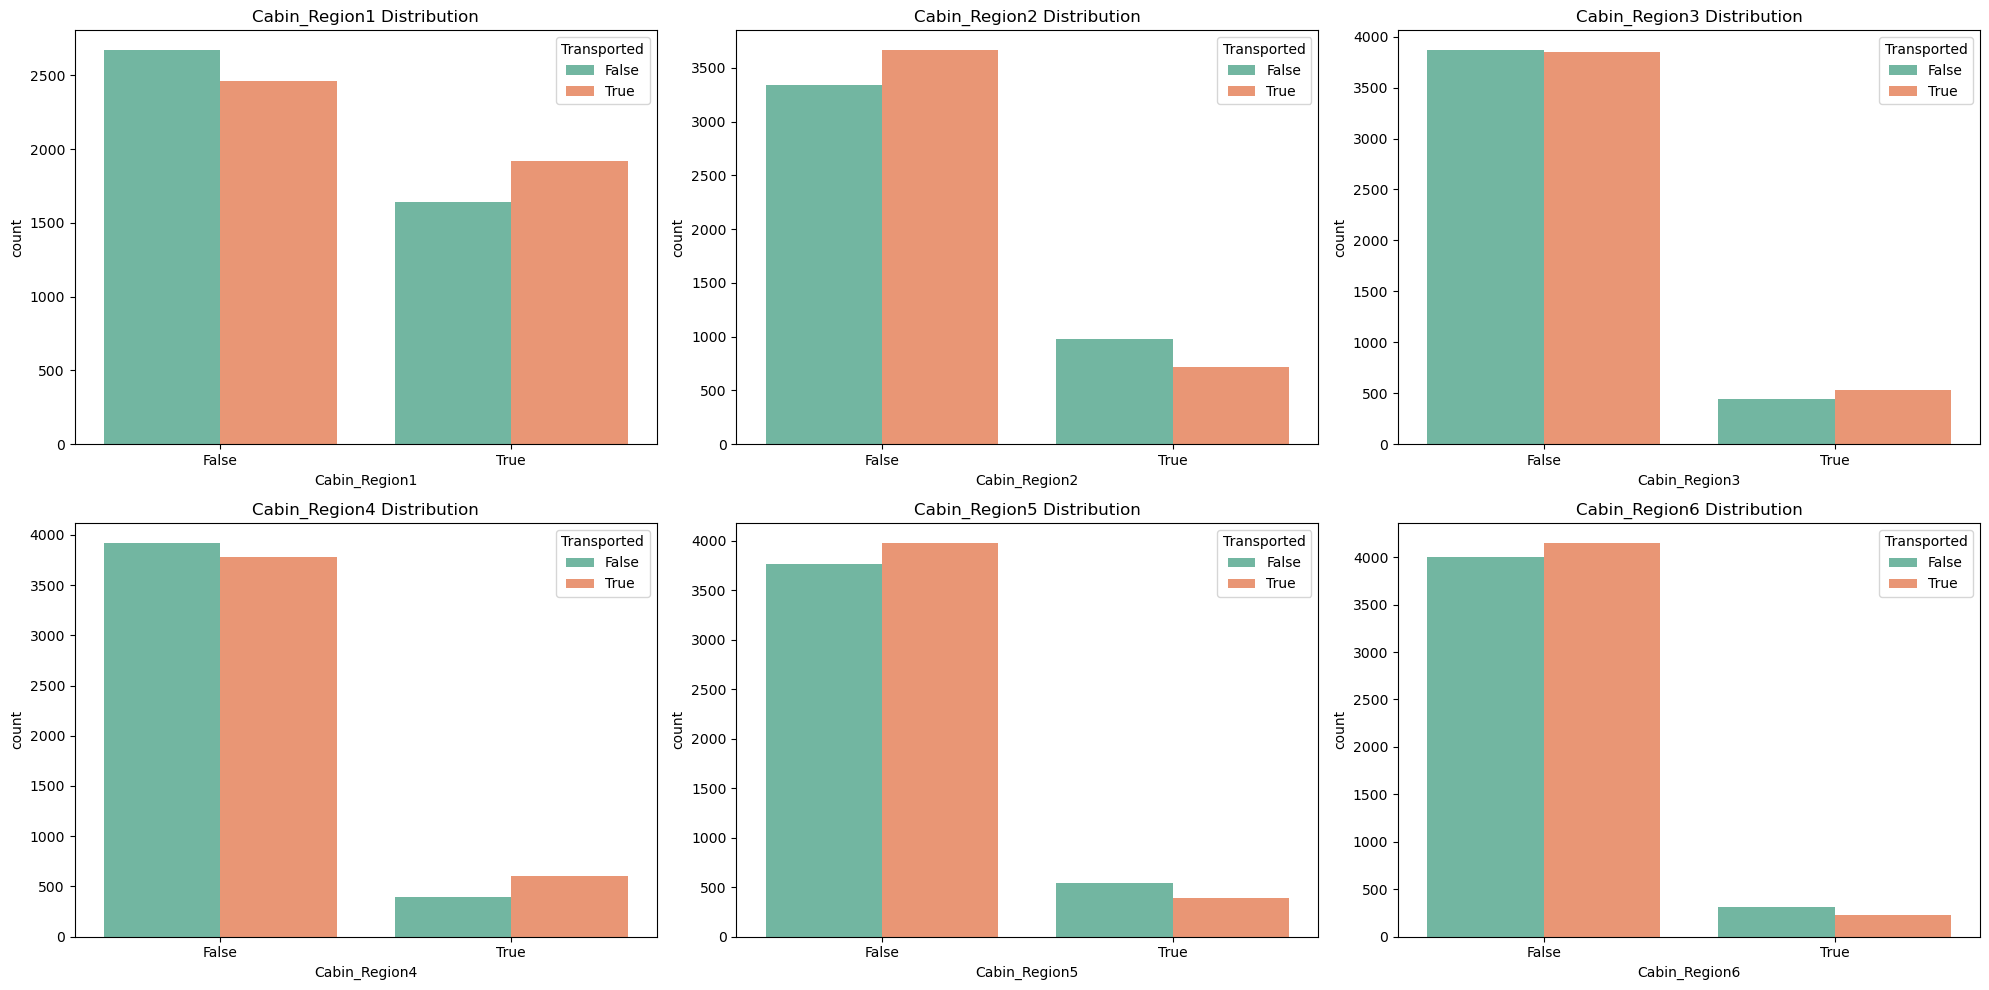

In [14]:
cols = ["Cabin_Region1","Cabin_Region2","Cabin_Region3","Cabin_Region4","Cabin_Region5","Cabin_Region6"]

plt.figure(figsize=(20,10))

for idx,value in enumerate(cols):
    plt.subplot(2,3,idx+1)
    sns.countplot(x=value, hue="Transported", data=train_df, palette="Set2")
    plt.title(f"{value} Distribution")
    plt.tight_layout()

### Observation
- Passengers from Cabin_Region1 are highly transported compared to other cabin regions.
- Additionally, there is a noticeable decrease in passenger transportation as the cabin region number increases.


### How we will do feature engineering on Age Feature
- After conducting Exploratory Data Analysis (EDA) on the Age feature, we gathered insights suggesting that ages can be categorized into different groups based on transportation.
- Therefore, we will create a new feature called Age Group and split the Age into different groups based on the insights gained from EDA.

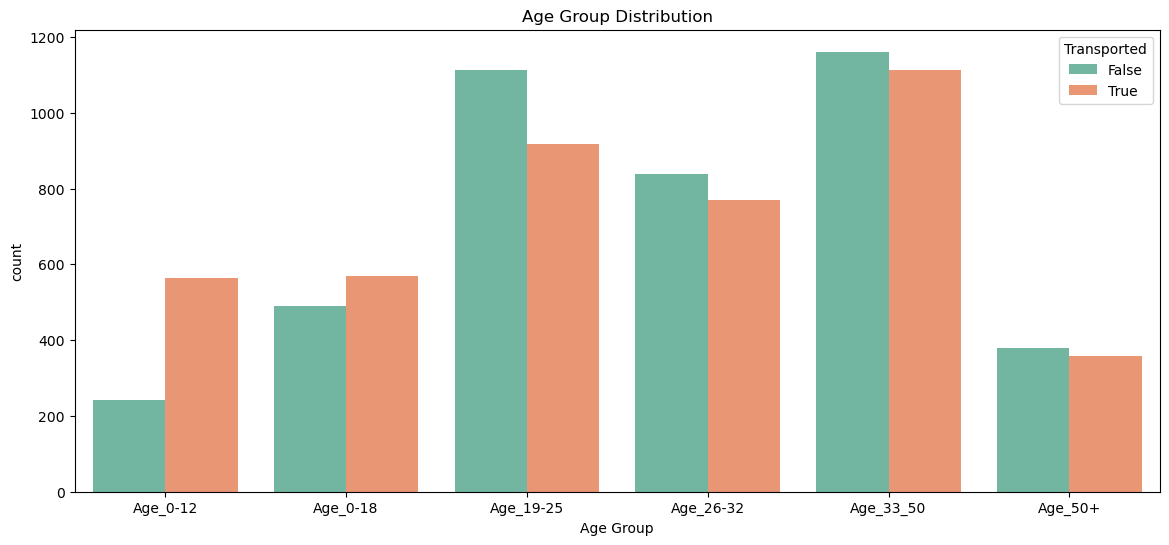

In [15]:
def age_group(df):
    age_group  = []
    for i in df["Age"]:
        if i<=12:
            age_group.append("Age_0-12")
        elif (i>12 and i<=18):
            age_group.append("Age_0-18")
        elif (i>18 and i<=25):
            age_group.append("Age_19-25")
        elif (i>25 and i<=32):
            age_group.append("Age_26-32")
        elif (i>32 and i<=50):
            age_group.append("Age_33_50")
        elif (i>50):
            age_group.append("Age_50+")
        else:
            age_group.append(np.nan)
        
    df["Age Group"] = age_group

age_group(train_df)
age_group(test_df)

order = sorted(train_df["Age Group"].value_counts().keys().to_list())

plt.figure(figsize=(14,6))
sns.countplot(x="Age Group",hue="Transported", data=train_df, palette="Set2",order=order)
plt.title("Age Group Distribution");

### Insights
- This new feature appears to be more relevant to our target data.
- Age groups 0-12 and 0-18 are more likely to be transported compared to not being transported.
- Age groups 19-25, 26-32, and 33-50 are less likely to be transported compared to not being transported.
- Age group 50+ is almost equally transported compared to not being transported.

### New All Expenditure Feature

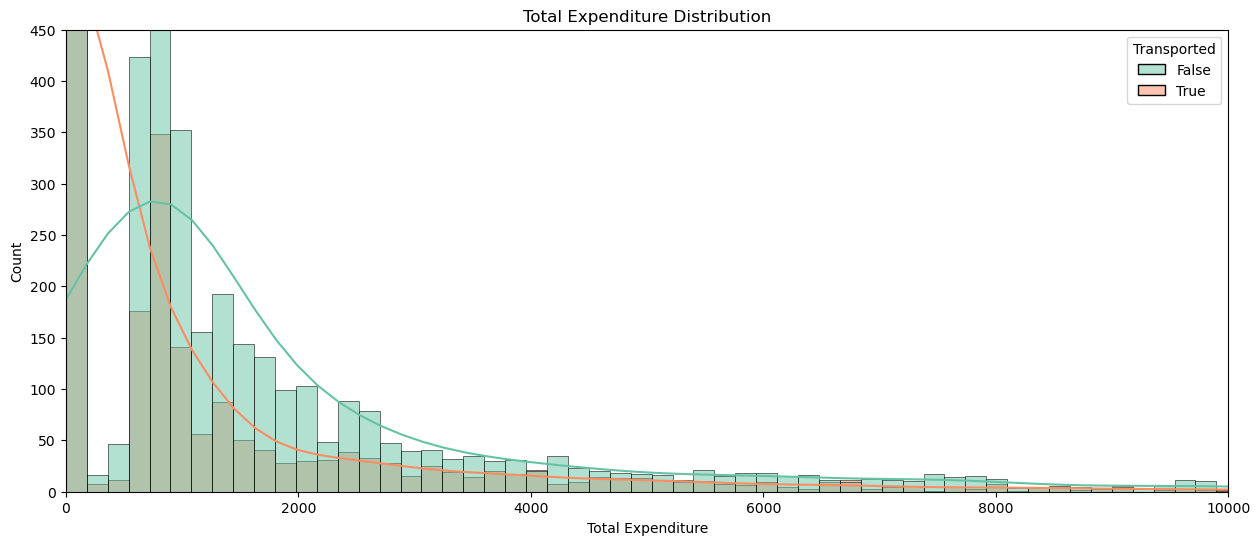

In [16]:
exp_cols = ["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]

def new_exp_features(df):
    df["Total Expenditure"] = df[exp_cols].sum(axis=1)
    df["No Spending"] = (df["Total Expenditure"]==0)

new_exp_features(train_df)
new_exp_features(test_df)

plt.figure(figsize=(15,6))
sns.histplot(x="Total Expenditure", hue="Transported", data=train_df, kde=True, palette="Set2",bins=200)
plt.ylim(0,450)
plt.xlim(0,10000)
plt.title("Total Expenditure Distribution");

In [17]:
mean = round(train_df["Total Expenditure"].mean())
median = train_df["Total Expenditure"].median()

print("Mean value of Total Expenditure feature is = ",mean)
print("Median value of Total Expenditure feature is = ",median)

Mean value of Total Expenditure feature is =  1441
Median value of Total Expenditure feature is =  716.0


### Insights

- Based on the measures of central tendency values provided above, we can categorize the Total Expenditure feature into different expense categories. 
- If Total Expenditure is equal to 0, it falls into the No Expense category.  
- If Total Expenditure is between 1 and 716, it falls into the Low Expense category.  
- If Total Expenditure is between 717 and 1441, it falls into the Medium Expense category.  
- If Total Expenditure is greater than 1441, it falls into the High Expense category.  

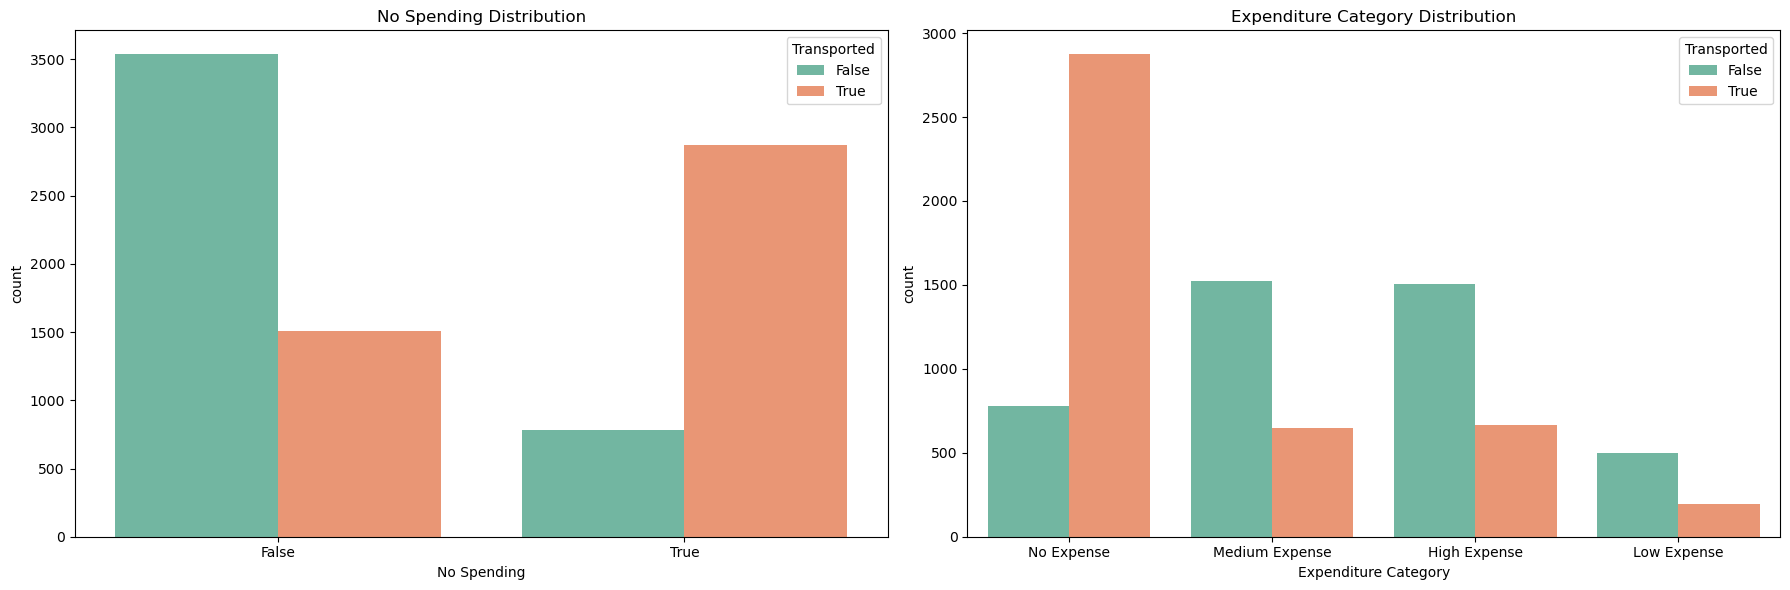

In [18]:
def expenditure_category(df):
    expense_category = []
    
    for i in df["Total Expenditure"]:
        if i==0:
            expense_category.append("No Expense")
        elif (i>0 and i<=716):
            expense_category.append("Low Expense")
        elif (i>716 and i<=1441):
            expense_category.append("Medium Expense")
        elif (i>1441):
            expense_category.append("High Expense")
    
    df["Expenditure Category"] = expense_category

expenditure_category(train_df)
expenditure_category(test_df)

cols = ["No Spending", "Expenditure Category"]

plt.figure(figsize=(18,6))
for idx,column in enumerate(cols):
    plt.subplot(1,2,idx+1)
    sns.countplot(x=column, hue="Transported", data=train_df, palette="Set2")
    plt.title(f"{column} Distribution")
    plt.tight_layout()

### Observation

  - Regarding the Total Expenditure feature, passengers with lower total expenses are more likely to be transported frequently.  
  - For the No Spending feature, passengers with no spending are observed to be transported at a high frequency.  
  - In the Expenditure Category feature, it's confirmed that passengers with no expenses are transported most frequently.  

# Final Data Preperation

In [19]:
cat_cols = train_df.select_dtypes(include=["object","bool"]).columns.tolist()
cat_cols.remove("Transported")
num_cols = train_df.select_dtypes(include=["int","float"]).columns.tolist()

print("Categorical Columns:",cat_cols)
print("\n","-"*120)
print("\nNumerical Columns:",num_cols)

Categorical Columns: ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name', 'Travelling_Solo', 'Cabin_Deck', 'Cabin_Side', 'Cabin_Region1', 'Cabin_Region2', 'Cabin_Region3', 'Cabin_Region4', 'Cabin_Region5', 'Cabin_Region6', 'Age Group', 'No Spending', 'Expenditure Category']

 ------------------------------------------------------------------------------------------------------------------------

Numerical Columns: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Group_Size', 'Total Expenditure']


### Impute missing values

In [20]:
imputer1 = SimpleImputer(strategy="most_frequent")     ##To fill Categorical Features.
imputer2 = SimpleImputer(strategy="median")            ##To fill numeircal features.

def fill_missingno(df):
    df[cat_cols] = imputer1.fit_transform(df[cat_cols])
    df[num_cols] = imputer2.fit_transform(df[num_cols])

fill_missingno(train_df)
fill_missingno(test_df)

print("Missing numbers left in train_df is:",train_df.isnull().sum().sum())
print("Missing numbers left in test_df is:",test_df.isnull().sum().sum())

Missing numbers left in train_df is: 0
Missing numbers left in test_df is: 0


### After feature engineering, drop data with high cardinality

In [21]:
print("Cardinality of features in numerical data is: ")
print(train_df.select_dtypes(include=["object"]).nunique())
print("\n","-"*50)
print("\nCardinality of features in categorical data is: ")
print(test_df.select_dtypes(include=["object"]).nunique())

# Extracting passengerId from test data because we need this for submitting our predictions on kaggle.
pass_df = test_df[["PassengerId"]]

cols = ["PassengerId","Cabin","Name"]
train_df.drop(columns =cols, inplace=True)
test_df.drop(columns=cols, inplace=True)

Cardinality of features in numerical data is: 
PassengerId             8693
HomePlanet                 3
CryoSleep                  2
Cabin                   6561
Destination                3
VIP                        2
Name                    8473
Travelling_Solo            2
Cabin_Deck                 8
Cabin_Side                 2
Cabin_Region1              2
Cabin_Region2              2
Cabin_Region3              2
Cabin_Region4              2
Cabin_Region5              2
Cabin_Region6              2
Age Group                  6
No Spending                2
Expenditure Category       4
dtype: int64

 --------------------------------------------------

Cardinality of features in categorical data is: 
PassengerId             4277
HomePlanet                 3
CryoSleep                  2
Cabin                   3266
Destination                3
VIP                        2
Name                    4176
Travelling_Solo            2
Cabin_Deck                 8
Cabin_Side               

In [22]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8693.0,28.790291,14.341404,0.0,20.0,27.0,37.0,79.0
RoomService,8693.0,220.009318,660.519050,0.0,0.0,0.0,41.0,14327.0
FoodCourt,8693.0,448.434027,1595.790627,0.0,0.0,0.0,61.0,29813.0
ShoppingMall,8693.0,169.572300,598.007164,0.0,0.0,0.0,22.0,23492.0
Spa,8693.0,304.588865,1125.562559,0.0,0.0,0.0,53.0,22408.0
VRDeck,8693.0,298.261820,1134.126417,0.0,0.0,0.0,40.0,24133.0
Group_Size,8693.0,2.035546,1.596347,1.0,1.0,1.0,3.0,8.0
Total Expenditure,8693.0,1440.866329,2803.045694,0.0,0.0,716.0,1441.0,35987.0


### Observation
-   We observe that in RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck, more than 50% of the data are equal to 0.
-   It was found that these features exhibit a right-skewed distribution.
-   Hence, it can be inferred that there is a significant presence of outliers in these features.
-   To address this issue, we propose transforming these features to a normal distribution using Log Transformation.
-   Since we are applying log transformation to these expenditure features, it's necessary to also apply the transformation to Total Expenditure.
-   This ensures that the model can better discern patterns within the data.


In [23]:
cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Total Expenditure']

for value in cols:
    train_df[value] = np.log(1+train_df[value])
    test_df[value]=np.log(1+test_df[value])

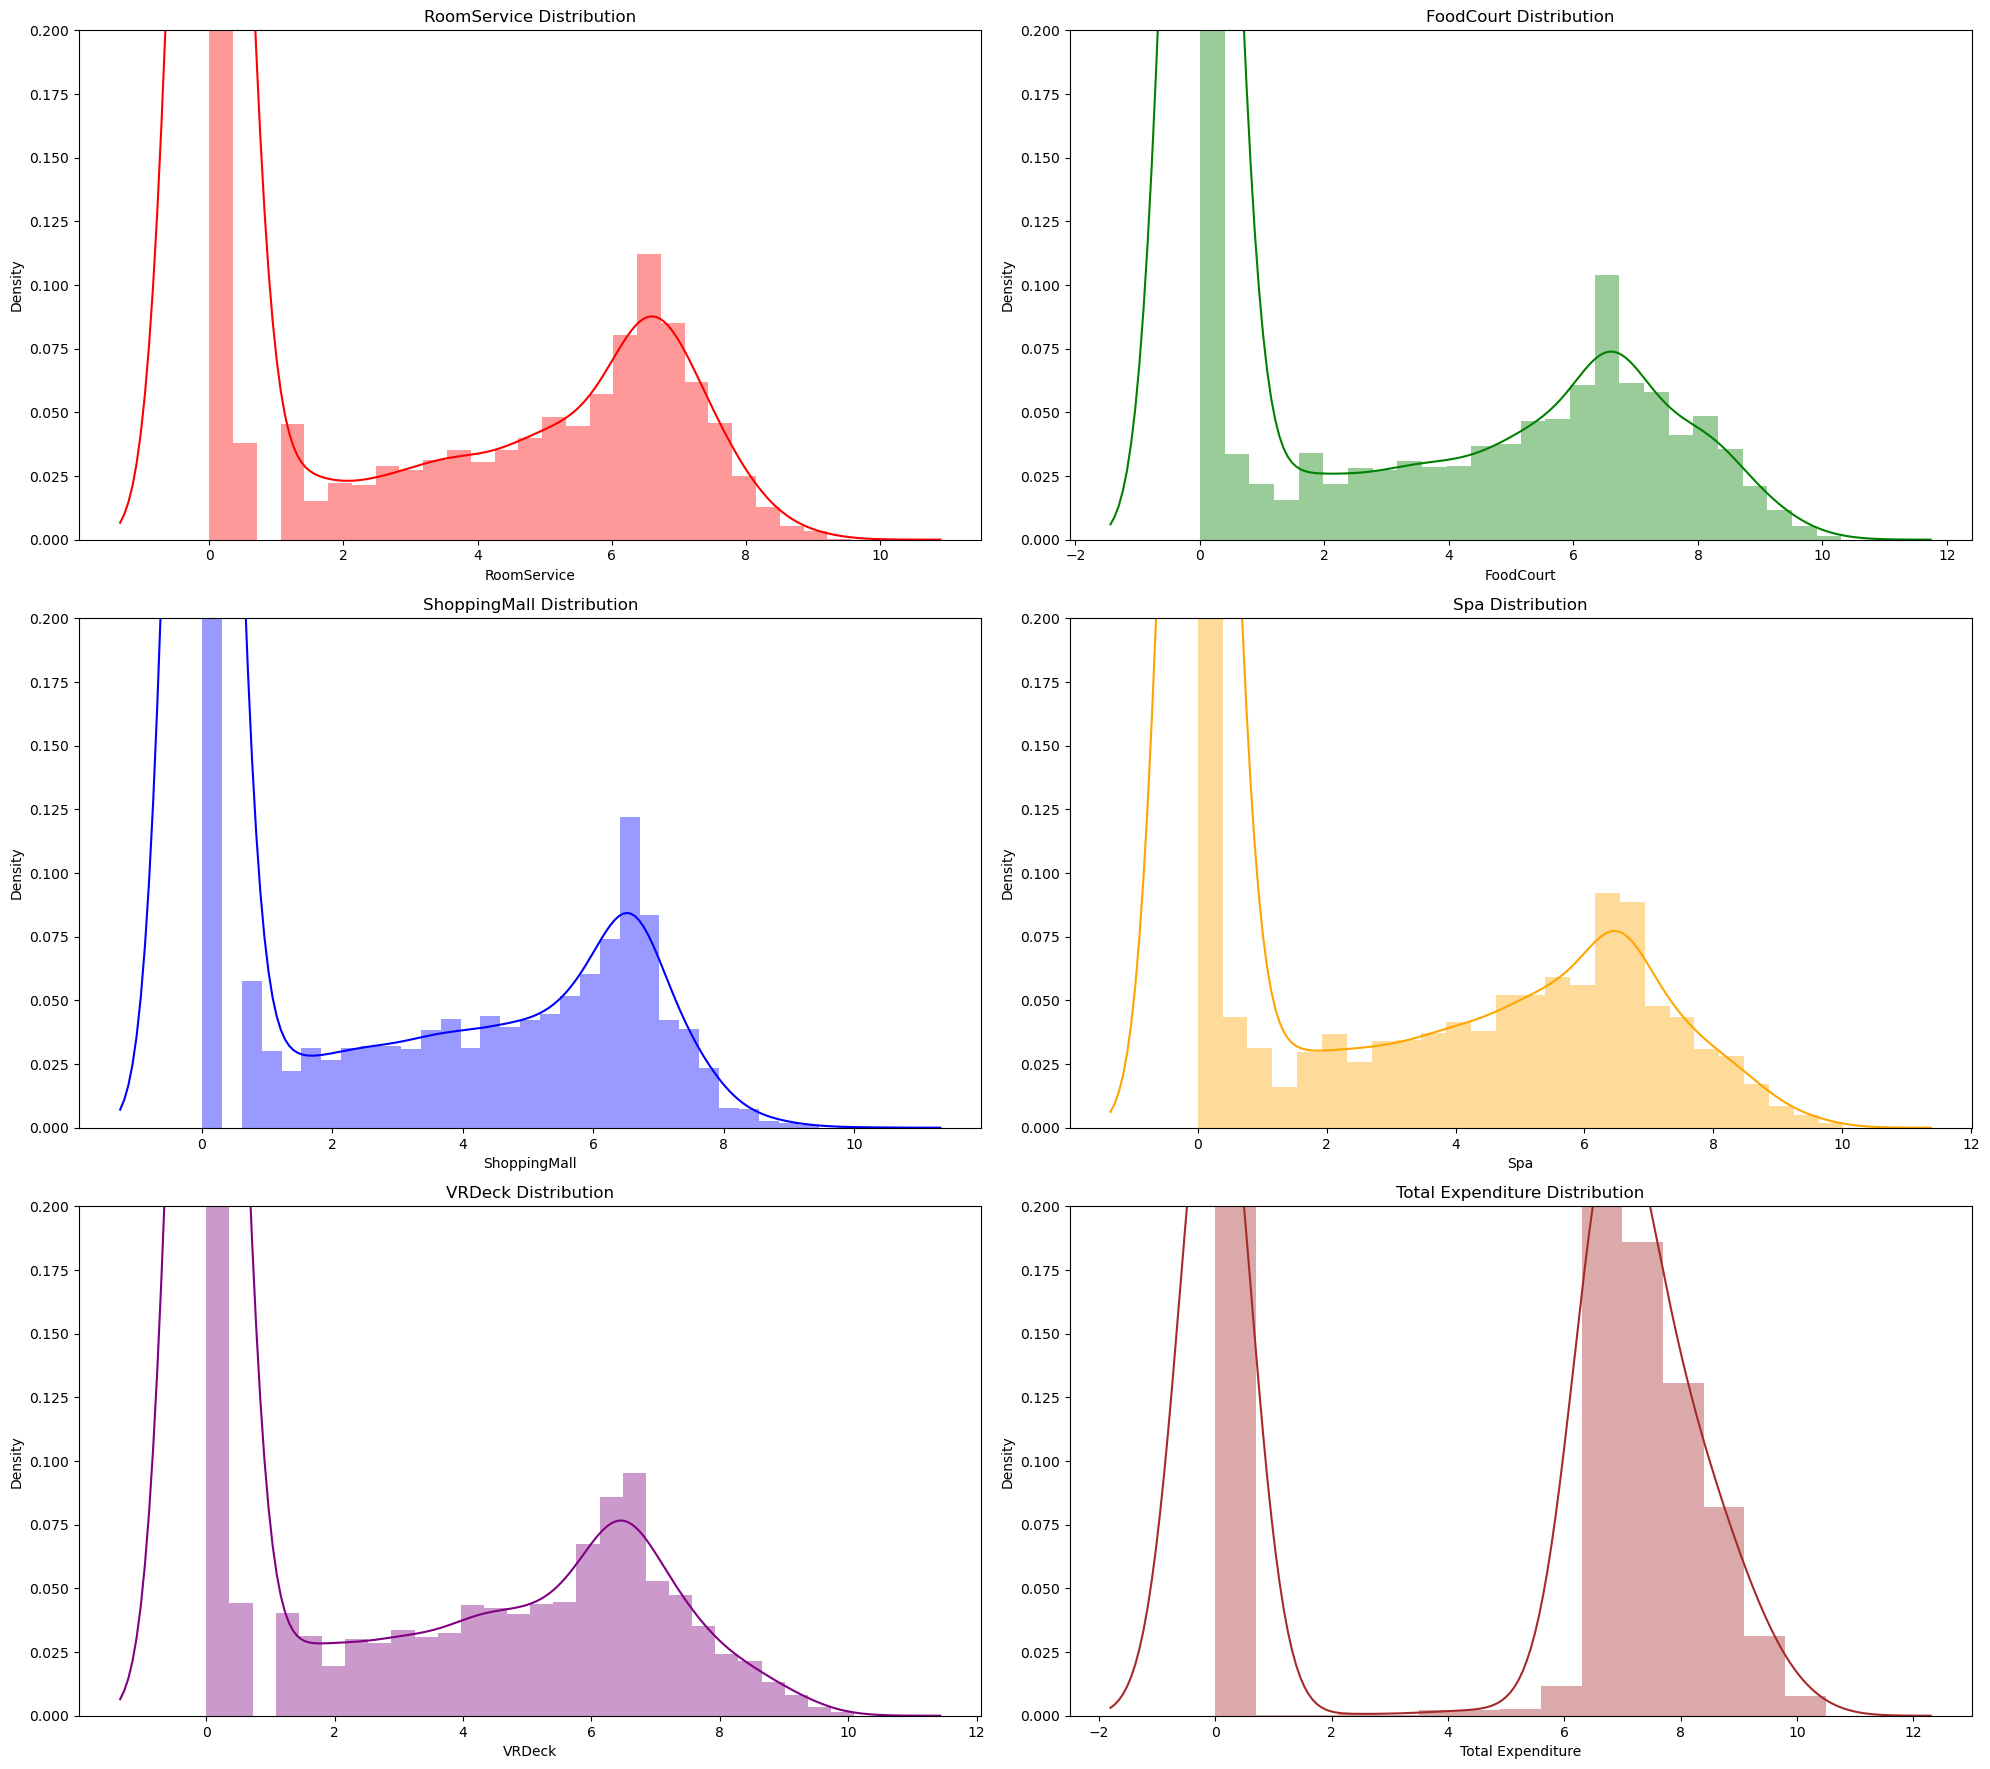

In [24]:
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown']

plt.figure(figsize=(20,35))
x=1

for i, color in zip(cols, colors):
    plt.subplot(6, 2, x)
    sns.distplot(train_df[i], color=color)  
    plt.ylim(0, 0.2)
    plt.title(f"{i} Distribution")
    plt.tight_layout()
    x += 1 

In [25]:
train_df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Cabin_Region1,Cabin_Region2,Cabin_Region3,Cabin_Region4,Cabin_Region5,Cabin_Region6,Age Group,Total Expenditure,No Spending,Expenditure Category
0,Europa,False,TRAPPIST-1e,39.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,...,True,False,False,False,False,False,Age_33_50,0.000000,True,No Expense
1,Earth,False,TRAPPIST-1e,24.0,False,4.700480,2.302585,3.258097,6.309918,3.806662,...,True,False,False,False,False,False,Age_19-25,6.602588,False,Medium Expense
2,Europa,False,TRAPPIST-1e,58.0,True,3.784190,8.182280,0.000000,8.812248,3.912023,...,True,False,False,False,False,False,Age_50+,9.248021,False,High Expense
3,Europa,False,TRAPPIST-1e,33.0,False,0.000000,7.157735,5.918894,8.110728,5.267858,...,True,False,False,False,False,False,Age_33_50,8.551981,False,High Expense
4,Earth,False,TRAPPIST-1e,16.0,False,5.717028,4.262680,5.023881,6.338594,1.098612,...,True,False,False,False,False,False,Age_0-18,6.995766,False,Medium Expense


### Changing Data-Type to Boolean

In [26]:
cols = ["CryoSleep","VIP","Travelling_Solo","No Spending","Cabin_Region1","Cabin_Region2","Cabin_Region3","Cabin_Region4",
       "Cabin_Region5","Cabin_Region6"]

train_df[cols] = train_df[cols].astype(bool)
test_df[cols] = test_df[cols].astype(bool)

### Feature Encoding

- We will do **One Hot Encoding** for nominal categorical features.
- We will do **LabelEncoding** for ordinal categorical features.

In [27]:
nominal_cat_cols = ["HomePlanet","Destination"]
ordinal_cat_cols = ["CryoSleep","VIP","Travelling_Solo","Cabin_Deck","Cabin_Side","Cabin_Region1","Cabin_Region2",
                    "Cabin_Region3","Cabin_Region4","Cabin_Region5","Cabin_Region6","Age Group","No Spending",
                    "Expenditure Category"]

# Label encoding
enc = LabelEncoder()

train_df[ordinal_cat_cols] = train_df[ordinal_cat_cols].apply(enc.fit_transform)
test_df[ordinal_cat_cols] = test_df[ordinal_cat_cols].apply(enc.fit_transform)

# One-hot encoding
train_df = pd.get_dummies(train_df,columns=nominal_cat_cols)
test_df = pd.get_dummies(test_df,columns=nominal_cat_cols)

train_df["Transported"].replace({False:0,True:1},inplace=True)

In [28]:
train_df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Travelling_Solo,...,Age Group,Total Expenditure,No Spending,Expenditure Category,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0,39.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,...,4,0.000000,1,3,False,True,False,False,False,True
1,0,24.0,0,4.700480,2.302585,3.258097,6.309918,3.806662,1,1,...,2,6.602588,0,2,True,False,False,False,False,True
2,0,58.0,1,3.784190,8.182280,0.000000,8.812248,3.912023,0,0,...,5,9.248021,0,0,False,True,False,False,False,True
3,0,33.0,0,0.000000,7.157735,5.918894,8.110728,5.267858,0,0,...,4,8.551981,0,0,False,True,False,False,False,True
4,0,16.0,0,5.717028,4.262680,5.023881,6.338594,1.098612,1,1,...,1,6.995766,0,2,True,False,False,False,False,True


### Now create training data sets

In [29]:
# Split data for training models 
X = train_df.drop(columns=["Transported"])
y = train_df[["Transported"]]

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, log_loss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

def evaluate_model(model_name, model, X_train, y_train, X_val, y_val):
    """
    Train a model, make predictions, and store performance metrics.

    Parameters:
    - model_name: str, the name of the model
    - model: the model instance
    - X_train: training features
    - y_train: training target variable
    - X_val: validation features
    - y_val: validation target variable
    """

    # Ensure metrics dictionary exists in the global scope
    global metrics

    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Predict probabilities for log loss calculation
    y_train_proba = model.predict_proba(X_train)
    y_val_proba = model.predict_proba(X_val)
    
    # Store metrics
    metrics["Model"].append(model_name)
    metrics["Accuracy (Train)"].append(accuracy_score(y_train, y_train_pred))
    metrics["Accuracy (Validation)"].append(accuracy_score(y_val, y_val_pred))
    metrics["Log Loss (Train)"].append(log_loss(y_train, y_train_proba))
    metrics["Log Loss (Validation)"].append(log_loss(y_val, y_val_proba))


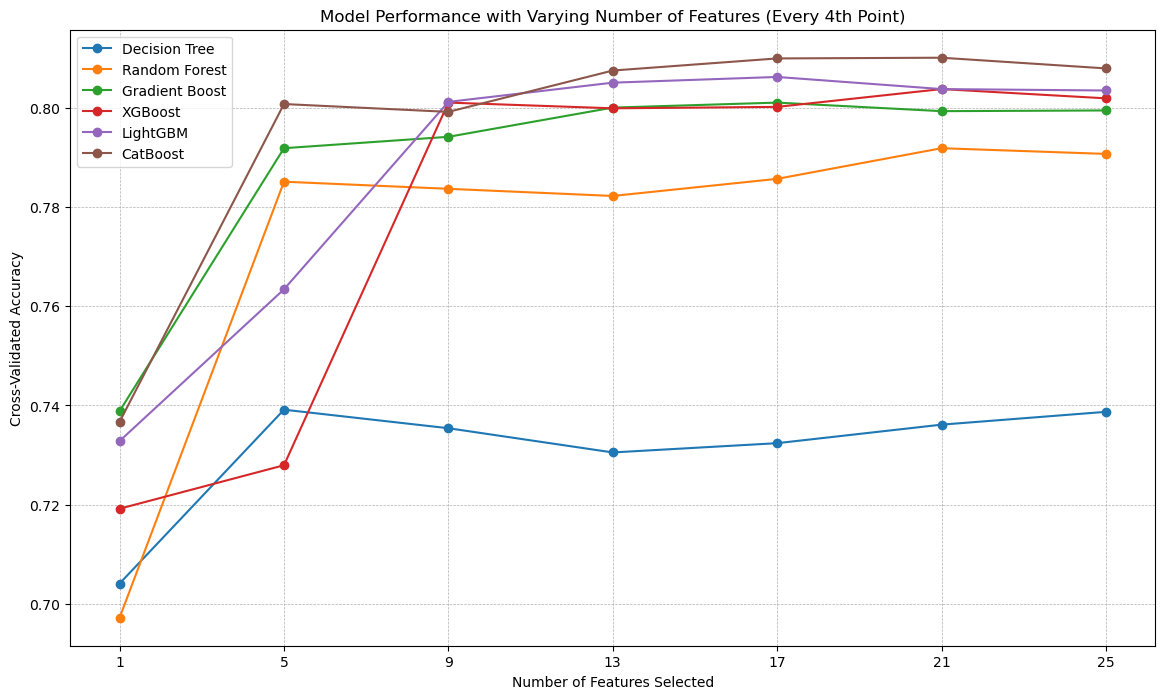

Features that give highest accuracy (per model):


,Model,Number of Features,Mean Accuracy,Selected Features
155,CatBoost,16,0.815646,"CryoSleep, Age, RoomService, FoodCourt, Shoppi..."
2,Decision Tree,3,0.752947,"FoodCourt, ShoppingMall, Total Expenditure"
73,Gradient Boost,18,0.801842,"CryoSleep, Age, RoomService, FoodCourt, Shoppi..."
130,LightGBM,19,0.807449,"CryoSleep, Age, RoomService, FoodCourt, Shoppi..."
38,Random Forest,11,0.792925,"CryoSleep, Age, RoomService, FoodCourt, Shoppi..."
97,XGBoost,14,0.805291,"CryoSleep, RoomService, FoodCourt, ShoppingMal..."


In [31]:
# Define your models here
models_optim = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boost": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1),
    "CatBoost": CatBoostClassifier(silent=True, random_state=42) 
}

data = []

feature_counts = range(1, 29) 

# Prepare the plot
plt.figure(figsize=(14, 8))

# Iterate over each model
for name, model in models_optim.items():
    mean_scores = []
    
    for n_features in feature_counts:
        # RFE with the current model and number of features
        selector = RFE(model, n_features_to_select=n_features, step=1)
        selector = selector.fit(x_train, y_train)
        
        # Train the model with selected features and assess performance using cross-validation
        scores = cross_val_score(model, x_train[x_train.columns[selector.support_]], y_train, cv=5, scoring='accuracy')
        mean_score = np.mean(scores)
        mean_scores.append(mean_score)
        
        # Store model name, number of features, mean accuracy, and selected features
        data.append({
            "Model": name,
            "Number of Features": n_features,
            "Mean Accuracy": mean_score,
            "Selected Features": ", ".join(x_train.columns[selector.support_])
        })

    # Select every 4th point for plotting (including the first point)
    selected_feature_counts = list(feature_counts)[::4]
    selected_mean_scores = mean_scores[::4]
    
    # Plotting the selected points for the current model
    plt.plot(selected_feature_counts, selected_mean_scores, marker='o', label=name)

# Finalizing the plot
plt.title('Model Performance with Varying Number of Features (Every 4th Point)')
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross-Validated Accuracy')
plt.xticks(selected_feature_counts)  # Adjust x-ticks to show only selected feature counts
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Convert the list of data into a DataFrame
results_df = pd.DataFrame(data)

# Group by 'Model' and find the index of the max 'Mean Accuracy' for each group
idx = results_df.groupby('Model')['Mean Accuracy'].idxmax()

# Use the cleaned idx to select the rows with the highest mean accuracy for each model
highest_accuracy_rows = results_df.loc[idx]

print('Features that give highest accuracy (per model):')

# Display the rows with the highest mean accuracy for each model
display(highest_accuracy_rows)


In [32]:
# Initialize the global metrics storage
metrics = {
    "Model": [],
    "Accuracy (Train)": [],
    "Accuracy (Validation)": [],
    "Log Loss (Train)": [],
    "Log Loss (Validation)": []
}

# Iterate over each model, using the function to train, predict, and store metrics
for name, model in models_optim.items():
    evaluate_model(name, model, x_train, y_train, x_test, y_test)

# Iterate over the rows in 'highest_accuracy_rows' to train models with their best feature sets
for index, row in highest_accuracy_rows.iterrows():
    model_name = row['Model']  # Model name
    selected_features = row['Selected Features'].split(", ")  # Extracting the list of best features for the model
    
    # Filter the training and validation datasets for the selected features
    x_train_selected = x_train[selected_features]
    x_test_selected = x_test[selected_features]
    
    # Retrieve the model from 'models_optim' dictionary
    model = models_optim[model_name]

    # Use the evaluate_model function to train the model and store performance metrics
    evaluate_model(f"{model_name} (RFE)", model, x_train_selected, y_train, x_test_selected, y_test)


# Convert metrics to a DataFrame for easier viewing
metrics_df = pd.DataFrame(metrics)
display(metrics_df)


,Model,Accuracy (Train),Accuracy (Validation),Log Loss (Train),Log Loss (Validation)
0,Decision Tree,0.985332,0.742956,0.022280,8.946569
1,Random Forest,0.985332,0.805635,0.125042,0.478687
2,Gradient Boost,0.820535,0.792984,0.380438,0.411866
3,XGBoost,0.927811,0.809661,0.203255,0.393969
4,LightGBM,0.883520,0.814836,0.270170,0.379668
5,CatBoost,0.873742,0.814261,0.289498,0.377811
6,CatBoost (RFE),0.867558,0.813686,0.293791,0.376793
7,Decision Tree (RFE),0.908542,0.737780,0.221274,6.220632
8,Gradient Boost (RFE),0.820823,0.794135,0.381892,0.411564
9,LightGBM (RFE),0.883520,0.820012,0.273886,0.381075


Model	Accuracy (Train)	Accuracy (Validation)	Log Loss (Train)	Log Loss (Validation)
0	Decision Tree	0.985332	0.742956	0.022280	8.946569
1	Random Forest	0.985332	0.805635	0.125042	0.478687
2	Gradient Boost	0.820535	0.792984	0.380438	0.411866
3	XGBoost	0.927811	0.809661	0.203255	0.393969
4	LightGBM	0.883520	0.814836	0.270170	0.379668
5	CatBoost	0.873742	0.814261	0.289498	0.377811
6	CatBoost (RFE)	0.867558	0.813686	0.293791	0.376793
7	Decision Tree (RFE)	0.908542	0.737780	0.221274	6.220632
8	Gradient Boost (RFE)	0.820823	0.794135	0.381892	0.411564
9	LightGBM (RFE)	0.883520	0.820012	0.273886	0.381075
10	Random Forest (RFE)	0.929393	0.781484	0.211082	0.637532
11	XGBoost (RFE)	0.894305	0.812536	0.240522	0.390156

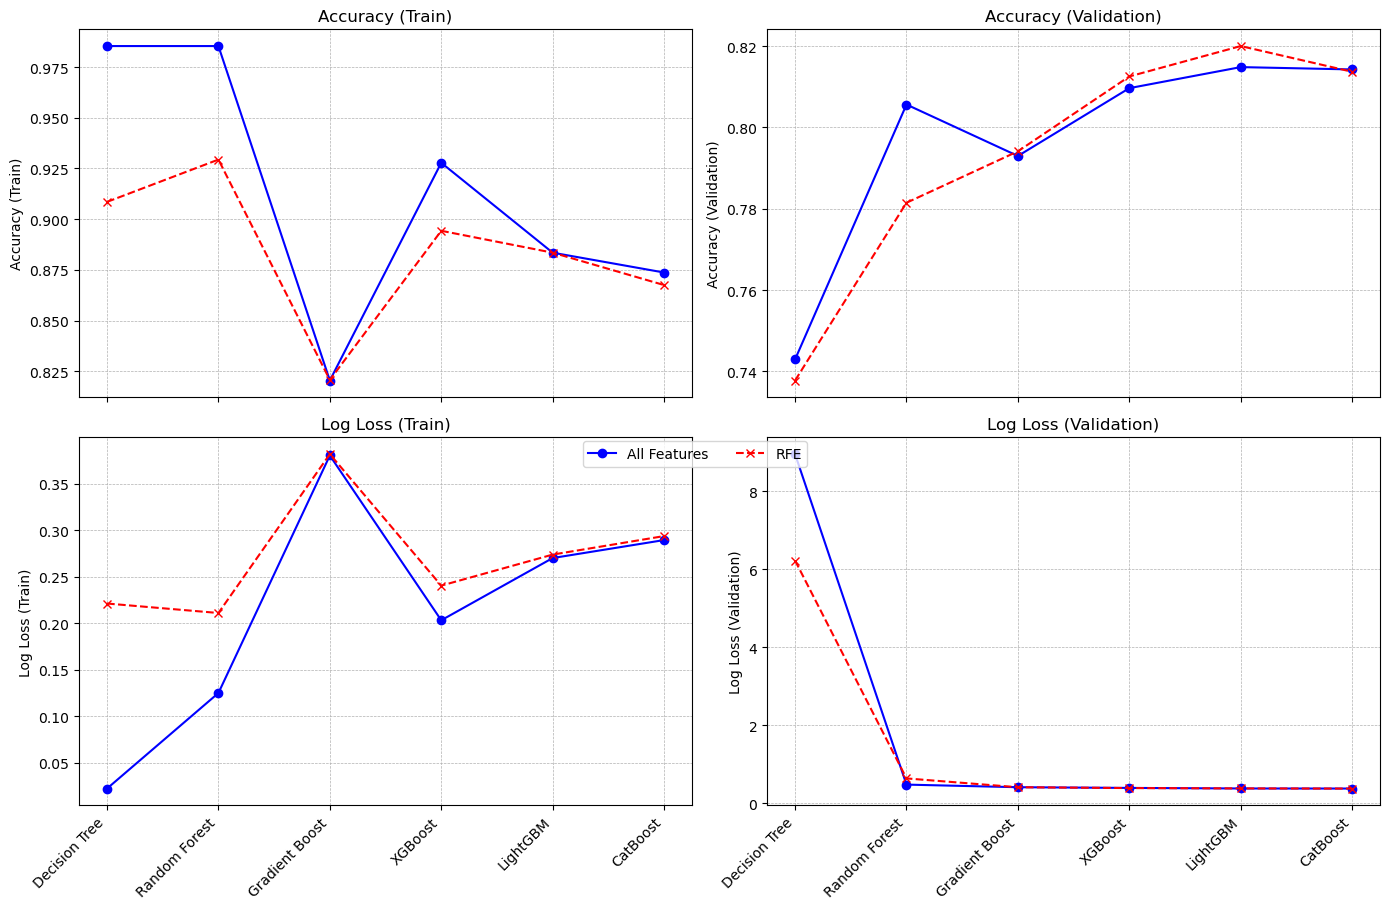

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Define your models and their RFE counterparts
models = ["Decision Tree", "Random Forest", "Gradient Boost", "XGBoost", "LightGBM", "CatBoost"]
metrics = ["Accuracy (Train)", "Accuracy (Validation)", "Log Loss (Train)", "Log Loss (Validation)"]

# Prepare the 2x2 subplot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10), sharex=True)

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]

    # Values for all features and RFE for each model
    all_features_values = []
    rfe_values = []

    for model in models:
        # Find corresponding rows for each model and its RFE version
        all_features_row = metrics_df.loc[metrics_df['Model'] == model]
        rfe_row = metrics_df.loc[metrics_df['Model'] == f"{model} (RFE)"]
        
        # Append metric values
        all_features_values.append(all_features_row[metric].values[0] if not all_features_row.empty else np.nan)
        rfe_values.append(rfe_row[metric].values[0] if not rfe_row.empty else np.nan)

    # Plot values
    x_ticks = np.arange(len(models))
    ax.plot(x_ticks, all_features_values, label="All Features", marker='o', linestyle='-', color='b')
    ax.plot(x_ticks, rfe_values, label="RFE", marker='x', linestyle='--', color='r')

    # Formatting
    ax.set_title(metric)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.set_ylabel(metric)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add a legend and adjust layout
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center', ncol=2)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Manual Bagging and Boosting

Both bagging and boosting are powerful ensemble techniques that can improve the performance of machine learning models by aggregating the results from multiple models. Bagging works best with complex models (like deep trees), whereas boosting is more effective with weak models (like shallow trees). The choice between bagging and boosting depends on the problem, the data at hand, and the complexity of the model being used. In practice, models like Random Forest, Gradient Boosting, XGBoost, LightGBM, and CatBoost have these techniques built-in, streamlining the process of creating robust predictive models.

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Initialize the base Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Initialize the Bagging Classifier
bagging_classifier = BaggingClassifier(base_estimator=dt_classifier, n_estimators=10, random_state=42)

# Initialize the AdaBoost Classifier
adaboost_classifier = AdaBoostClassifier(base_estimator=dt_classifier, n_estimators=50, random_state=42)

# Initialize dictionaries to hold various metrics
training_accuracy = {}
validation_accuracy = {}
log_loss_train = {}
log_loss_validation = {}

# Evaluate and update metrics for Decision Tree
dt_classifier.fit(x_train, y_train)
dt_train_pred = dt_classifier.predict(x_train)
dt_val_pred = dt_classifier.predict(x_test)
training_accuracy['Decision Tree'] = accuracy_score(y_train, dt_train_pred)
validation_accuracy['Decision Tree'] = accuracy_score(y_test, dt_val_pred)
log_loss_train['Decision Tree'] = log_loss(y_train, dt_classifier.predict_proba(x_train))
log_loss_validation['Decision Tree'] = log_loss(y_test, dt_classifier.predict_proba(x_test))

# Evaluate and update metrics for Bagging Classifier
bagging_classifier.fit(x_train, y_train)
bagging_train_pred = bagging_classifier.predict(x_train)
bagging_val_pred = bagging_classifier.predict(x_test)
training_accuracy['Bagging'] = accuracy_score(y_train, bagging_train_pred)
validation_accuracy['Bagging'] = accuracy_score(y_test, bagging_val_pred)
log_loss_train['Bagging'] = log_loss(y_train, bagging_classifier.predict_proba(x_train))
log_loss_validation['Bagging'] = log_loss(y_test, bagging_classifier.predict_proba(x_test))

# Evaluate and update metrics for AdaBoost Classifier
adaboost_classifier.fit(x_train, y_train)
adaboost_train_pred = adaboost_classifier.predict(x_train)
adaboost_val_pred = adaboost_classifier.predict(x_test)
training_accuracy['AdaBoost'] = accuracy_score(y_train, adaboost_train_pred)
validation_accuracy['AdaBoost'] = accuracy_score(y_test, adaboost_val_pred)
log_loss_train['AdaBoost'] = log_loss(y_train, adaboost_classifier.predict_proba(x_train))
log_loss_validation['AdaBoost'] = log_loss(y_test, adaboost_classifier.predict_proba(x_test))

# Extract Random Forest metrics for "Random Tree" from metrics_df
random_tree_val_acc = metrics_df.loc[metrics_df['Model'] == 'Random Forest', 'Accuracy (Validation)'].values[0]
random_tree_log_loss_val = metrics_df.loc[metrics_df['Model'] == 'Random Forest', 'Log Loss (Validation)'].values[0]
random_tree_train_acc = metrics_df.loc[metrics_df['Model'] == 'Random Forest', 'Accuracy (Train)'].values[0]
random_tree_log_loss_train = metrics_df.loc[metrics_df['Model'] == 'Random Forest', 'Log Loss (Train)'].values[0]

# Update training and validation dictionaries for "Random Tree"
training_accuracy['Random Tree'] = random_tree_train_acc
log_loss_train['Random Tree'] = random_tree_log_loss_train
validation_accuracy['Random Tree'] = random_tree_val_acc
log_loss_validation['Random Tree'] = random_tree_log_loss_val

# Combine the metrics into a DataFrame for a structured display
metrics_df_combined = pd.DataFrame({
    'Method': list(validation_accuracy.keys()),
    'Training Accuracy': list(training_accuracy.values()),
    'Validation Accuracy': list(validation_accuracy.values()),
    'Log Loss (Train)': list(log_loss_train.values()),
    'Log Loss (Validation)': list(log_loss_validation.values())
})

# Display the DataFrame
display(metrics_df_combined)

,Method,Training Accuracy,Validation Accuracy,Log Loss (Train),Log Loss (Validation)
0,Decision Tree,0.985332,0.742956,0.022280,8.946569
1,Bagging,0.973828,0.789534,0.126757,0.961989
2,AdaBoost,0.985332,0.740656,0.023044,6.078989
3,Random Tree,0.985332,0.805635,0.125042,0.478687


# Hyper-Parameter tuning

We will begin hyper tuning the best performing models.

In [40]:
# Define your models here
best_models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boost": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1),
    "CatBoost": CatBoostClassifier(silent=True, random_state=42) 
}

# Define hyperparameter grids for each model
hyperparameter_grids = {
    "Random Forest": {
        'n_estimators': [100, 300, 500, 550],
        'min_samples_split': [7, 8, 9],
        'max_depth': [10, 11, 12], 
        'min_samples_leaf': [4, 5, 6]
    },
    "Gradient Boost": {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.05, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'max_depth': [3, 4, 5]
    },
    "XGBoost": {
        "n_estimators": [50, 100, 150],
        "random_state": [0, 42, 50],
        "learning_rate": [0.1, 0.3, 0.5, 1.0]
    },
    "LightGBM": {
        "n_estimators": [100, 300, 500, 600, 650],
        "learning_rate": [0.01, 0.02, 0.03],
        "random_state": [0, 42, 48, 50],
        "num_leaves": [16, 17, 18]
    },
    "CatBoost": {
        "learning_rate": [0.1, 0.3, 0.5, 0.6, 0.7],
        "random_state": [0, 42, 48, 50],
        "depth": [8, 9, 10],
        "iterations": [35, 40, 50]
    }
}

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

# Initialize a dictionary to store the best models
best_trained_models = {}

# Perform hyperparameter search and train models
for model_name, model in best_models.items():
    if model_name in hyperparameter_grids:
        # Set up the hyperparameter search
        grid_search = GridSearchCV(model, hyperparameter_grids[model_name], cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
        
        # Perform the search
        print(f"Performing grid search for {model_name}...")
        grid_search.fit(x_train, y_train)
        
        # Retrieve the best model
        best_trained_models[model_name] = grid_search.best_estimator_
        
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        print(f"Best score for {model_name}: {grid_search.best_score_}\n")


Performing grid search for Random Forest...


/Users/yuravbeo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yuravbeo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yuravbeo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yuravbeo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:

Best parameters for Random Forest: {'max_depth': 12, 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 550}
Best score for Random Forest: 0.7999714505893488

Performing grid search for Gradient Boost...


/Users/yuravbeo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuravbeo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuravbeo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuravbeo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

Best parameters for Gradient Boost: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best score for Gradient Boost: 0.8070173623861516

Performing grid search for XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 0}
Best score for XGBoost: 0.8078796373397328

Performing grid search for LightGBM...


/Users/yuravbeo/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuravbeo/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuravbeo/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuravbeo/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array 

Best parameters for LightGBM: {'learning_rate': 0.01, 'n_estimators': 500, 'num_leaves': 17, 'random_state': 0}
Best score for LightGBM: 0.8094625780324698

Performing grid search for CatBoost...
Best parameters for CatBoost: {'depth': 8, 'iterations': 50, 'learning_rate': 0.1, 'random_state': 42}
Best score for CatBoost: 0.8061551908724638



In [ ]:
'''
Best parameters for Random Forest: {'max_depth': 12, 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 550}
Best score for Random Forest: 0.7999714505893488

Best parameters for Gradient Boost: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best score for Gradient Boost: 0.8070173623861516

Performing grid search for XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 0}
Best score for XGBoost: 0.8078796373397328

Best parameters for LightGBM: {'learning_rate': 0.01, 'n_estimators': 500, 'num_leaves': 17, 'random_state': 0}
Best score for LightGBM: 0.8094625780324698

Performing grid search for CatBoost...
Best parameters for CatBoost: {'depth': 8, 'iterations': 50, 'learning_rate': 0.1, 'random_state': 42}
Best score for CatBoost: 0.8061551908724638
 '''

"\nBest parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 100}\nBest score for Random Forest: 0.8064428572167428\n\nBest parameters for Gradient Boost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.9}\nBest score for Gradient Boost: 0.8132009992293728\n\nPerforming grid search for XGBoost...\nFitting 5 folds for each of 36 candidates, totalling 180 fits\nBest parameters for XGBoost: {'learning_rate': 0.1, 'n_estimators': 100, 'random_state': 0}\nBest score for XGBoost: 0.815215180838794\n\nBest parameters for LightGBM: {'learning_rate': 0.02, 'n_estimators': 600, 'num_leaves': 17, 'random_state': 0}\nBest score for LightGBM: 0.8143520783660634\n\nPerforming grid search for CatBoost...\nFitting 5 folds for each of 180 candidates, totalling 900 fits\nBest parameters for CatBoost: {'depth': 9, 'iterations': 50, 'learning_rate': 0.1, 'random_state': 48}\nBest score for CatBoost: 0.8129134363249875\n "

# Stacking Classifier

In [42]:
# Prepare the base estimators for the stacking classifier
estimators = [(model_name, model) for model_name, model in best_trained_models.items()]

# Initialize the stacking classifier
stacking_classifier = StackingClassifier(
    estimators=[('gb', best_trained_models['Gradient Boost']),
                ('xgb', best_trained_models['XGBoost']),
                ('lgb', best_trained_models['LightGBM']),
                ('catboost', best_trained_models['CatBoost'])]
)

# Train the stacking classifier
print("Training the stacking classifier...")

stacking_classifier.fit(x_train, y_train)

x_train_pred = stacking_classifier.predict(x_train)
print("Stacking Model accuracy on Training Data is:",accuracy_score(y_train,x_train_pred)*100)

x_test_pred = stacking_classifier.predict(x_test)
print("Stacking Model accuracy on Testing Data is:",accuracy_score(y_test,x_test_pred)*100)

Training the stacking classifier...
Stacking Model accuracy on Training Data is: 84.28242737992522
Stacking Model accuracy on Testing Data is: 80.33352501437608


In [43]:
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV

# Define the search space
search_spaces = {
    'gb__n_estimators': Integer(100, 500),
    'gb__learning_rate': Real(0.01, 0.5, 'log-uniform'),
    'gb__max_depth': Integer(3, 10),

    'xgb__n_estimators': Integer(100, 500),
    'xgb__learning_rate': Real(0.01, 0.5, 'log-uniform'),
    'xgb__max_depth': Integer(3, 10),
    'xgb__subsample': Real(0.5, 1.0),
    'xgb__colsample_bytree': Real(0.5, 1.0),

    'lgb__n_estimators': Integer(100, 500),
    'lgb__learning_rate': Real(0.01, 0.5, 'log-uniform'),
    'lgb__num_leaves': Integer(20, 40),
    'lgb__max_depth': Integer(3, 10),
    'lgb__feature_fraction': Real(0.5, 1.0),

    'catboost__iterations': Integer(100, 500),
    'catboost__learning_rate': Real(0.01, 0.5, 'log-uniform'),
    'catboost__depth': Integer(3, 10),
    'catboost__l2_leaf_reg': Real(1, 10),
}

# Set up the Bayes search
bayes_search = BayesSearchCV(estimator=stacking_classifier, 
                             search_spaces=search_spaces,
                             n_iter=50, 
                             cv=5, 
                             n_jobs=-1)


# Train the stacking classifier
print("Training the bayes classifier...")

# Perform the search on your training data
bayes_search.fit(x_train, y_train)

x_train_pred = bayes_search.predict(x_train)
print("Stacking Model accuracy on Training Data is:",accuracy_score(y_train,x_train_pred)*100)

x_test_pred = bayes_search.predict(x_test)
print("Stacking Model accuracy on Testing Data is:",accuracy_score(y_test,x_test_pred)*100)

Training the bayes classifier...


/Users/yuravbeo/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuravbeo/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/yuravbeo/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuravbeo/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y

KeyboardInterrupt: 

In [ ]:
pred = bayes_search.predict(test_df)

pass_df["Transported"] = pred
pass_df["Transported"].replace({1:True,0:False},inplace=True)

pass_df.to_csv("stacking_estimator_after_bayes.csv",index=False)

# Voting Ensemble

In [44]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# Initialize the voting classifier
# Note: 'voting' can be 'hard' for majority voting or 'soft' for averaging probabilities in classification problems.
voting_classifier = VotingClassifier(
    estimators=[
        ('gb', best_trained_models['Gradient Boost']),
        ('xgb', best_trained_models['XGBoost']),
        ('lgb', best_trained_models['LightGBM']),
        ('catboost', best_trained_models['CatBoost'])
    ],
    voting='hard'  # Use 'soft' if your models provide predict_proba method for soft voting
)

# Train the voting classifier
print("Training the voting classifier...")

voting_classifier.fit(x_train, y_train)

x_train_pred = voting_classifier.predict(x_train)
print("Voting Model accuracy on Training Data is:", accuracy_score(y_train, x_train_pred) * 100)

x_test_pred = voting_classifier.predict(x_test)
print("Voting Model accuracy on Testing Data is:", accuracy_score(y_test, x_test_pred) * 100)


Training the voting classifier...
Voting Model accuracy on Training Data is: 84.77135461604833
Voting Model accuracy on Testing Data is: 80.67855089131685


# LightGBm alone


In [ ]:
pred = best_trained_models['LightGBM'].predict(test_df)

pass_df["Transported"] = pred
pass_df["Transported"].replace({1:True,0:False},inplace=True)

pass_df.to_csv("lgbm.csv",index=False)

In [ ]:
pred = best_trained_models['XGBoost'].predict(test_df)

pass_df["Transported"] = pred
pass_df["Transported"].replace({1:True,0:False},inplace=True)

pass_df.to_csv("xgBoost.csv",index=False)

In [ ]:
search_spaces = {
        'n_estimators': (100, 1000),
        'num_leaves': (31, 200),
        'learning_rate': (0.001, 0.1),
        'subsample': (0.5, 1.0),
        'colsample_bytree': (0.3, 1.0),
        'min_child_weight': (0.001, 0.1),
        'reg_alpha': (0, 1),
        'reg_lambda': (0, 1)
}

bayes_search_lgbm = BayesSearchCV(estimator=best_trained_models['LightGBM'], 
                             search_spaces=search_spaces,
                             n_iter=50, 
                             cv=5, 
                             n_jobs=-1)

# Train the stacking classifier
print("Training the bayes classifier for lgbm...")

# Perform the search on your training data
bayes_search_lgbm.fit(x_train, y_train)

x_train_pred = bayes_search_lgbm.predict(x_train)
print("LGBM Model accuracy on Training Data is:",accuracy_score(y_train,x_train_pred)*100)

x_test_pred = bayes_search_lgbm.predict(x_test)
print("LGBM Model accuracy on Testing Data is:",accuracy_score(y_test,x_test_pred)*100)

Training the bayes classifier for lgbm...


/Users/yuravbeo/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuravbeo/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/yuravbeo/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuravbeo/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y

Stacking Model accuracy on Training Data is: 89.93385102099512
Stacking Model accuracy on Testing Data is: 81.82863714778608


In [ ]:
pred = bayes_search_lgbm.predict(test_df)

pass_df["Transported"] = pred
pass_df["Transported"].replace({1:True,0:False},inplace=True)

pass_df.to_csv("lgbm_bayes_search.csv",index=False)

# Try grid RFE

In [ ]:
import warnings
from itertools import combinations
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# Suppress specific LightGBM warnings
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

# Initialize the best score and best features
best_score = 0
best_features = None

# Get the feature columns from your dataset
features = x_train.columns

# Iterate over all possible non-empty combinations of features
for r in range(1, len(features) + 1):
    for combo in combinations(features, r):
        # Subset x_train and X_valid to use only the current combination of features
        x_train_sub = x_train[list(combo)]
        X_valid_sub = x_test[list(combo)]

        # Initialize and train the LightGBM model with verbosity turned off
        model = LGBMClassifier(verbose=-1)
        model.fit(x_train_sub, y_train)

        # Make predictions on the validation set and calculate the accuracy
        preds = model.predict(X_valid_sub)
        score = accuracy_score(y_test, preds)

        # Print the accuracy score for the current combination
        print(f'Combination: {combo}, Accuracy: {score:.4f}, Best score: {best_score:.4f}')

        # Update the best score and features if the current score is better
        if score > best_score:
            best_score = score
            best_features = combo

# Print the best score and the combination of features that achieved it
print(f'Best score: {best_score:.4f}')
print(f'Best features: {best_features}')


Combination: ('CryoSleep',), Accuracy: 0.7148, Best score: 0.0000
Combination: ('Age',), Accuracy: 0.5532, Best score: 0.7148
Combination: ('VIP',), Accuracy: 0.5049, Best score: 0.7148
Combination: ('RoomService',), Accuracy: 0.6527, Best score: 0.7148
Combination: ('FoodCourt',), Accuracy: 0.6170, Best score: 0.7148
Combination: ('ShoppingMall',), Accuracy: 0.6136, Best score: 0.7148
Combination: ('Spa',), Accuracy: 0.6578, Best score: 0.7148
Combination: ('VRDeck',), Accuracy: 0.6613, Best score: 0.7148
Combination: ('Travelling_Solo',), Accuracy: 0.5618, Best score: 0.7148
Combination: ('Group_Size',), Accuracy: 0.5647, Best score: 0.7148
Combination: ('Cabin_Deck',), Accuracy: 0.5641, Best score: 0.7148
Combination: ('Cabin_Side',), Accuracy: 0.5595, Best score: 0.7148
Combination: ('Cabin_Region1',), Accuracy: 0.5325, Best score: 0.7148
Combination: ('Cabin_Region2',), Accuracy: 0.5377, Best score: 0.7148
Combination: ('Cabin_Region3',), Accuracy: 0.5147, Best score: 0.7148
Combi

KeyboardInterrupt: 

# Successive Half Searching

In [ ]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from lightgbm import LGBMClassifier
import numpy as np


# Specify the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'num_leaves': [31, 62, 127],
    'max_depth': [3, 5, 7],
}

# Initialize HalvingGridSearchCV
# `factor` controls the rate at which candidates are removed
# `min_resources` is the minimum amount of resource each candidate is allocated
search = HalvingGridSearchCV(estimator=best_trained_models['LightGBM'], param_grid=param_grid, factor=2, min_resources='exhaust', cv=5)

# Fit the HalvingGridSearchCV to your data
# Replace `X_train` and `y_train` with your training data and labels
search.fit(x_train, y_train)

# Best hyperparameters found
print("Best hyperparameters: ", search.best_params_)

# You can also use the best model directly
best_model = search.best_estimator_

x_train_pred = search.predict(x_train)
print("LGBM Model (Successive halfing) accuracy on Training Data is:",accuracy_score(y_train,x_train_pred)*100)

x_test_pred = search.predict(x_test)
print("LGBM Model (Successive halfing) accuracy on Testing Data is:",accuracy_score(y_test,x_test_pred)*100)

Best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'num_leaves': 62}
LGBM Model (Successive halfing) accuracy on Training Data is: 83.14639056658038
LGBM Model (Successive halfing) accuracy on Testing Data is: 80.21851638872916


In [ ]:
pred = search.predict(test_df)

pass_df["Transported"] = pred
pass_df["Transported"].replace({1:True,0:False},inplace=True)

pass_df.to_csv("lgmb_successive_halfing.csv",index=False)

# Neural networks

In [ ]:
import tensorflow as tf
import numpy as np

# Assuming 'x_train' and 'y_train' are your data, convert them to float32
x_train_neural = x_train.astype('float32')
y_train_neural = y_train.astype('float32')

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train_neural, y_train_neural, epochs=10, batch_size=32, validation_split=0.2)

# Extract the history of training/validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Find the maximum training accuracy and minimum training loss
max_train_acc = max(acc)
min_train_loss = min(loss)

# Find the maximum validation accuracy and minimum validation loss
max_val_acc = max(val_acc)
min_val_loss = min(val_loss)

# Display the results
print(f"Highest Training Accuracy: {max_train_acc:.4f}")
print(f"Lowest Training Loss: {min_train_loss:.4f}")
print(f"Highest Validation Accuracy: {max_val_acc:.4f}")
print(f"Lowest Validation Loss: {min_val_loss:.4f}")


Epoch 1/10
174/174 [==============================] - 0s 815us/step - loss: 0.7425 - accuracy: 0.6455 - val_loss: 0.5317 - val_accuracy: 0.7728
Epoch 2/10
174/174 [==============================] - 0s 509us/step - loss: 0.5828 - accuracy: 0.7097 - val_loss: 0.4969 - val_accuracy: 0.7649
Epoch 3/10
174/174 [==============================] - 0s 658us/step - loss: 0.5458 - accuracy: 0.7340 - val_loss: 0.4756 - val_accuracy: 0.7879
Epoch 4/10
174/174 [==============================] - 0s 473us/step - loss: 0.5229 - accuracy: 0.7519 - val_loss: 0.4672 - val_accuracy: 0.7894
Epoch 5/10
174/174 [==============================] - 0s 480us/step - loss: 0.5170 - accuracy: 0.7516 - val_loss: 0.4611 - val_accuracy: 0.7915
Epoch 6/10
174/174 [==============================] - 0s 449us/step - loss: 0.5004 - accuracy: 0.7602 - val_loss: 0.4624 - val_accuracy: 0.7973
Epoch 7/10
174/174 [==============================] - 0s 443us/step - loss: 0.4930 - accuracy: 0.7642 - val_loss: 0.4532 - val_accuracy:

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow logs below ERROR level
import tensorflow as tf
import numpy as np

# Assuming 'x_train' and 'y_train' are your data, converted to float32
x_train_neural = x_train.astype('float32')
y_train_neural = y_train.astype('float32')

# Sample hyperparameters to iterate over
nodes_list = [32, 64, 128, 256, 512]  # Number of nodes in the hidden layer
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]  # Learning rates
optimizers = {
    'adam': tf.keras.optimizers.legacy.Adam,
    'sgd': tf.keras.optimizers.legacy.SGD,
    'rmsprop': tf.keras.optimizers.legacy.RMSprop,  # Added RMSprop optimizer
    'adamax': tf.keras.optimizers.legacy.Adamax  # Added Adamax optimizer
}
loss_functions = {
    'binary_crossentropy': 'binary_crossentropy',
    'log_loss': tf.keras.losses.BinaryCrossentropy(),
    'hinge_loss': 'hinge',  # Added hinge loss, suitable for binary classification tasks
    'squared_hinge_loss': 'squared_hinge'  # Added squared hinge loss, a variant of hinge loss
}

# Placeholder for best model and performance
best_model = None
best_val_acc = 0
best_config = {}

for nodes in nodes_list:
    for lr in learning_rates:
        for opt_name, opt in optimizers.items():
            for loss_name, loss in loss_functions.items():
                # Define the model
                model = tf.keras.Sequential([
                    tf.keras.layers.Dense(nodes, activation='relu', input_shape=(x_train.shape[1],)),
                    tf.keras.layers.Dropout(0.5),
                    tf.keras.layers.Dense(nodes, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')
                ])

                # Compile the model with the current set of hyperparameters
                optimizer = opt(learning_rate=lr)
                model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

                # Train the model
                history = model.fit(
                    x_train_neural, y_train_neural,
                    epochs=25,  # Adjust this as necessary
                    batch_size=64,  # Adjust this as necessary
                    validation_split=0.2,
                    verbose=0  # Set to 0 to suppress training logs
                )

                # Evaluate the model
                val_acc = max(history.history['val_accuracy'])
                print(f"Nodes: {nodes}, LR: {lr}, Optimizer: {opt_name}, Loss: {loss_name}, Val Acc: {val_acc:.4f}")

                # Update best model if current model is better
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_model = model
                    best_config = {
                        'nodes': nodes,
                        'learning_rate': lr,
                        'optimizer': opt_name,
                        'loss_function': loss_name
                    }

# Print out the best configuration and its validation accuracy
print(f"\nBest Configuration: {best_config}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")


Nodes: 32, LR: 0.001, Optimizer: adam, Loss: binary_crossentropy, Val Acc: 0.8030
Nodes: 32, LR: 0.001, Optimizer: adam, Loss: log_loss, Val Acc: 0.7937
Nodes: 32, LR: 0.001, Optimizer: adam, Loss: hinge_loss, Val Acc: 0.7901
Nodes: 32, LR: 0.001, Optimizer: adam, Loss: squared_hinge_loss, Val Acc: 0.7534
Nodes: 32, LR: 0.001, Optimizer: sgd, Loss: binary_crossentropy, Val Acc: 0.7541
Nodes: 32, LR: 0.001, Optimizer: sgd, Loss: log_loss, Val Acc: 0.7534
Nodes: 32, LR: 0.001, Optimizer: sgd, Loss: hinge_loss, Val Acc: 0.7563
Nodes: 32, LR: 0.001, Optimizer: sgd, Loss: squared_hinge_loss, Val Acc: 0.5018
Nodes: 32, LR: 0.001, Optimizer: rmsprop, Loss: binary_crossentropy, Val Acc: 0.7958
Nodes: 32, LR: 0.001, Optimizer: rmsprop, Loss: log_loss, Val Acc: 0.8030
Nodes: 32, LR: 0.001, Optimizer: rmsprop, Loss: hinge_loss, Val Acc: 0.7872
Nodes: 32, LR: 0.001, Optimizer: rmsprop, Loss: squared_hinge_loss, Val Acc: 0.7455
Nodes: 32, LR: 0.001, Optimizer: adamax, Loss: binary_crossentropy, Val

In [ ]:
test_df_neural = test_df.astype('float32')

pred = best_model.predict(test_df_neural)

pred = pred > 0.5

pass_df["Transported"] = pred
pass_df["Transported"].replace({1:True,0:False},inplace=True)

pass_df.to_csv("neural_net.csv",index=False)

# 78 on kaggle

134/134 [==============================] - 0s 468us/step


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam, SGD  # Use legacy optimizers
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow logs

# Initial configuration
config = {
    'nodes': 64,
    'learning_rate': 0.001,
    'optimizer': 'adam',  # Starting with adam optimizer
    'loss_function': 'binary_crossentropy'
}

# Increment values for each hyperparameter
increments = {
    'nodes': 32,  # Increment nodes by 32 each time
    'learning_rate': 0.001  # Increment learning rate by 0.001 each time
}

# Function to create, compile, and evaluate a model
def evaluate_model(config):
    model = Sequential([
        Dense(config['nodes'], activation='relu', input_shape=(x_train_neural.shape[1],)),
        Dropout(0.5),
        Dense(config['nodes'], activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    if config['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=config['learning_rate'])
    else:  # config['optimizer'] == 'sgd'
        optimizer = SGD(learning_rate=config['learning_rate'])

    model.compile(optimizer=optimizer, loss=config['loss_function'], metrics=['accuracy'])
    model.fit(x_train_neural, y_train_neural, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
    _, accuracy = model.evaluate(x_train_neural, y_train_neural, verbose=0)

    return accuracy

best_accuracy = 0

# Iteratively update hyperparameters
for _ in range(100):  # Number of iterations
    for param in increments:
        # Try increasing the hyperparameter
        config[param] += increments[param]
        accuracy = evaluate_model(config)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            print(f"Improved {param} to {config[param]} with accuracy {accuracy:.4f}")
        else:
            # If not better, try decreasing the hyperparameter
            config[param] -= 2 * increments[param]  # Subtract twice because we added once before
            accuracy = evaluate_model(config)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                print(f"Improved {param} to {config[param]} with accuracy {accuracy:.4f}")
            else:
                # Revert to original value if neither increasing nor decreasing improves accuracy
                config[param] += increments[param]

print("\nBest configuration:", config)
print(f"Best accuracy: {best_accuracy:.4f}")


Improved nodes to 96 with accuracy 0.8034
Improved learning_rate to 0.002 with accuracy 0.8036
Improved nodes to 128 with accuracy 0.8049
Improved nodes to 96 with accuracy 0.8070
Improved nodes to 128 with accuracy 0.8097
Improved nodes to 160 with accuracy 0.8116

Best configuration: {'nodes': 160, 'learning_rate': 0.002, 'optimizer': 'adam', 'loss_function': 'binary_crossentropy'}
Best accuracy: 0.8116


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Assuming 'x_train_neural' and 'y_train_neural' are your training data and labels
# You might need to adjust input_shape according to your dataset's features
input_shape = x_train_neural.shape[1]

# Best configuration from your optimization
best_config = {
    'nodes': 160,
    'learning_rate': 0.002,
    'optimizer': 'adam',  # Using Adam optimizer
    'loss_function': 'binary_crossentropy'
}

# Define the model
model = Sequential([
    Dense(best_config['nodes'], activation='relu', input_shape=(input_shape,)),
    Dropout(0.5),  # Using a dropout layer to reduce overfitting
    Dense(best_config['nodes'], activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming it's a binary classification problem
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=best_config['learning_rate']),
              loss=best_config['loss_function'],
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train_neural, y_train_neural,
                    epochs=100,  # Adjust epochs based on your requirements
                    batch_size=32,  # Batch size can be tuned as well
                    validation_split=0.2,  # Using part of the training data for validation
                    verbose=0)

# Evaluate the model on the training data
# Note: For a true evaluation, you should evaluate on a separate test set
_, train_accuracy = model.evaluate(x_train_neural, y_train_neural, verbose=0)

print(f"Training Accuracy: {train_accuracy:.4f}")



Training Accuracy: 0.8414


In [ ]:
pred = model.predict(test_df_neural)

pred = pred > 0.5

pass_df["Transported"] = pred
pass_df["Transported"].replace({1:True,0:False},inplace=True)

pass_df.to_csv("neural_net_optimized.csv",index=False)

134/134 [==============================] - 0s 247us/step
